In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Packages

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import importlib
from fastprogress import master_bar, progress_bar

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
from sklearn.metrics import recall_score, balanced_accuracy_score
from sklearn.metrics import average_precision_score, log_loss
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble, preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_rel, ttest_ind

%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Utility functions:

In [32]:
# instantiate a model using the parameters and import source
def get_model(model_name:str, import_module:str, model_params:dict):
    model_class = getattr(importlib.import_module(import_module), model_name)
    model = model_class(**model_params) # Instantiates the model
    return model

# returns the p_values for the each value except the best for each column
def p_stats(raw_data, raw_mean, rows, cols, per_data=False):
    # get index of algo with highest performance for each metric or dataset (in each column)
    best_algo_in_cols = raw_mean.to_numpy().argmax(axis=0)
    algo_raw = []

    for alg in raw_data:
        if per_data:
            # due to the way data is store
            algo_raw.append(np.split(alg.flatten(), cols))
        else:
            algo_raw.append(np.split(alg.flatten('F'), cols))

    p_val_test = np.ones_like(raw_mean)

    # for each metric, get the best performing algo first
    for col in range(cols):
        idx = best_algo_in_cols[col]
        # get raw data for best algo and metric(col)
        best_raw = algo_raw[idx][col]
        # run t-test between this algo(idx) and other algos
        for id_alg in range(rows):
            if (id_alg == idx): 
                continue
            else:
                # run t-test between this and the best
                this_raw = algo_raw[id_alg][col]
                t_stat, p_stat = ttest_ind(best_raw, this_raw, nan_policy='omit')
                p_val_test[id_alg][col] = p_stat
    return p_val_test

def plot_roc_pr(real_y, prob_y, algo_name, data_name):
    fig, axes = plt.subplots(1,2, figsize=(12,10))
    # for roc_auc_curve
    # roc_score = roc_auc_score(real_y, prob_y)
    
    fpr, tpr, _ = roc_curve(real_y, prob_y)
    lab1 = 'ROC Area=%.2f' % (auc(fpr, tpr))
    axes[0].plot([1, 0], [1, 0], color='red', lw=2, linestyle='--', label='Diagonal')
    axes[0].step(fpr, tpr, label=lab1, lw=2, color='black')
    axes[0].set_title((algo_name)+ ", Data: " + str(data_name))
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend(loc='lower left')
    # set same size for two subplots
    asp0 = np.diff(axes[0].get_xlim())[0] / np.diff(axes[0].get_ylim())[0]
    axes[0].set_aspect(asp0)
    # for precision-recall
    precision, recall, _ = precision_recall_curve(real_y, prob_y)
    ave_PR = average_precision_score(real_y, prob_y)
    lab2 = 'PR AUC=%.2f' % (ave_PR)
    # add diagonal line
    axes[1].plot([0.0, 1.0], [1.0, 0.0], color='red', lw=2, linestyle='--', label='Diagonal')
    axes[1].step(recall, precision, label=lab2, lw=2, color='black')
    axes[1].set_title((algo_name)+ ", Data: " + str(data_name))
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend(loc='lower left')
    asp1 = np.diff(axes[1].get_xlim())[0] / np.diff(axes[1].get_ylim())[0]
    axes[1].set_aspect(asp1)
    plt.show()
    fig.tight_layout()

# Load cleaned data:

In [ ]:
ADULT = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/cleaned/adult.csv').drop('Unnamed: 0', axis=1)
LETTER1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/cleaned/letter_p1.csv').drop('Unnamed: 0', axis=1)
LETTER2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/cleaned/letter_p2.csv').drop('Unnamed: 0', axis=1)
COVTYPE = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/cleaned/covtype5.csv').drop('Unnamed: 0', axis=1)

# Algorithms and their parameters:

In [ ]:
print([i for i in range(1, 11, 2)])

[1, 3, 5, 7, 9]


In [ ]:
LOGIT = {'name' : 'LogisticRegression()',
            'name_str' : 'LogisticRegression',
            'module' : 'sklearn.linear_model',
            'hyperparameters' : {
                 'solver': ['liblinear'],
                 'C' : [10**i for i in range(-8, 4)],
                 }
            }

TREES = {'name' : 'DecisionTreeClassifier()',
          'name_str' : 'DecisionTreeClassifier',
          'module' : 'sklearn.tree',
          'hyperparameters' : {
              'criterion': ['gini', 'entropy'], 
            #   'ccp_alpha': np.arange(0, 1, 0.1).tolist(), 
              'max_depth': [i for i in range(1, 26, 3)],
              'min_samples_split': [i for i in range(1, 10, 2)],
              'min_samples_leaf': [1,3,5,7],
              }
         }

FOREST = {'name' : 'RandomForestClassifier()',
          'name_str' : 'RandomForestClassifier',
          'module' : 'sklearn.ensemble',
          'hyperparameters' : {
              'n_estimators' : [2**i for i in range(1, 11)], 
              'max_features' : [1,2,4,6,8,12,16,20],
              }
          }

GBOOST = {'name' : 'GradientBoostingClassifier()',
             'name_str' : 'GradientBoostingClassifier',
             'module' : 'sklearn.ensemble',
             'hyperparameters' : {
                 'n_estimators' : [2,4,8,16,32,64,128,256,512,1024,2048],
                 'max_depth': [i for i in range(1, 10, 2)], 
                 }
              }

MLP_ADAM = {'name' : 'MLPClassifier()',
       'name_str' : 'MLPClassifier',
       'module' : 'sklearn.neural_network',
       'hyperparameters' : {
           'hidden_layer_sizes' : [1,2,4,8,32,128,256], 
           }
            }

NB = {'name' : 'BernoulliNB()',
             'name_str' : 'BernoulliNB',
             'module' : 'sklearn.naive_bayes',
             'hyperparameters' : {
                 'alpha' : [10**i for i in range(-4, 4)]
                 }}

# Function and variables for training classifiers

In [ ]:
TRIALS = 5
CV_NUM = 5

# add all datasets/algos to a list
data_list = [ADULT, LETTER1, LETTER2, COVTYPE]
algorithms = [LOGIT, TREES, FOREST, GBOOST, MLP_ADAM, NB]  

# string names of variables used for printing
dataset_names =  ['ADULT', 'LETTER1', 'LETTER2', 'COVTYPE']
algo_names = ['LOGIT', 'TREES', 'FOREST', 'GBOOST', 'MLP_ADAM', 'NB'] 
metric_names = ['ACC','APR','ROC']
scorings = {'ACC':'accuracy', 'APR': 'average_precision','ROC' : 'roc_auc'}

# metrics used
scorers = [accuracy_score, average_precision_score, roc_auc_score]

# scores of each algorithm by data set (averaged over all metrics)
algo_data_df = pd.DataFrame(0.0, index=algo_names, columns=dataset_names)

# scores for each algorithm by metric (average over all data sets)
algo_metric_df_train = pd.DataFrame(0.0, index=algo_names, columns=metric_names)
algo_metric_df_test = pd.DataFrame(0.0, index=algo_names, columns=metric_names)

# for each algo, store raw train/test scores for each dataset
# number_of_dataset by trails by number_of_metrics
raw_train = np.zeros((len(algorithms), len(dataset_names), TRIALS, len(metric_names)))
raw_test = np.zeros((len(algorithms), len(dataset_names), TRIALS, len(metric_names)))


# work on one algorithm
def learn(idx_algo, algo):
    start = time.time()
    print('\n--------------------------------------------------------------\n')
    print(f'Started training {algo["name"]}')

    # for this algo, store training metrics averaged across all datasets after the loop over data_list
    metric_across_data_train = np.zeros((len(dataset_names), len(metric_names)))

    # for this algo, store testing metrics averaged across all datasets after the loop over data_list
    metric_across_data_test = np.zeros((len(dataset_names), len(metric_names)))

    # for this algo, store raw training metrics 
    # for each dataset, there is 3 metrics. For each metric, there is 5 trials
    raw_metric_data_train = np.zeros((len(dataset_names), TRIALS, len(metric_names)))

    # for this algo, store raw training metrics 
    raw_metric_data_test = np.zeros((len(dataset_names), TRIALS, len(metric_names)))

    # loop over all datasets
    for idx_data, data in enumerate(progress_bar(data_list)):
        start_data = time.time()
        print(f'Started on {dataset_names[idx_data]} dataset')

        # for each algo/data combo, store testing metrics averaged across 5 trials
        metric_across_trials_test = np.zeros((TRIALS, len(metric_names)))
        # for each algo/data combo, store training metrics averaged across 5 trials
        metric_across_trials_train = np.zeros((TRIALS, len(metric_names)))

        # data for precision-recall curve
        auc_real_y = []
        auc_prob_y = []

        # loop over all trials
        for trial in progress_bar(range(TRIALS)):
            start_trial = time.time()
            print("Started trial: ", trial+1)

            # pick 5000 samples for training 
            X = data.drop('y', axis=1)
            Y = data['y']
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=5000, random_state=trial)

            # only scale data for MLP's or LOGREG
            if (algo['name_str'] in ['MLPClassifier', 'LogisticRegression']):
                scaler = StandardScaler()
                X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
                X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

            clf = eval(algo['name'])
            param = algo['hyperparameters']
            
            # Get each parameter that has best performance on validation set

            CV = GridSearchCV(clf, param, cv=CV_NUM, n_jobs=-1, scoring=scorings, refit='ACC')
            CV.fit(X_train, Y_train)
            result_cv = CV.cv_results_

            print("\nBest param for ACC:", CV.best_params_)

            # get parameters for best models for each metric
            param_list = []
            for metric in metric_names:
                best_id = pd.Series(result_cv['rank_test_'+str(metric)]).idxmin()
                param_list.append(result_cv['params'][best_id])

            # Train n models using the 5000 samples and each of the n best parameters
            # and test on test set
            clf_name = algo['name_str']
            module = algo['module']
            train_metrics = []
            test_metrics = []
        
            for i in range(len(param_list)):
                clf_best = get_model(clf_name, module, param_list[i])
                clf_best.fit(X_train,Y_train)

                # for roc_auc and PR curves
                pred_proba = clf_best.predict_proba(X_test)
                auc_real_y.append(Y_test)
                auc_prob_y.append(pred_proba[:,1])

                X_train_pred = clf_best.predict(X_train)
                X_test_pred = clf_best.predict(X_test)
                X_train_pred_prob = clf_best.predict_proba(X_train)
                X_test_pred_prob = clf_best.predict_proba(X_test)

                # get appropriate scoring function
                scorer = scorers[i]

                # if metric is average precision, need y-score or proba
                if (i==1):
                    train_metrics.append(scorer(Y_train, X_train_pred_prob[:, 1]))
                    test_metrics.append(scorer(Y_test, X_test_pred_prob[:, 1]))
                # if scorer is roc_auc, need proba
                elif (i==2):
                    train_metrics.append(scorer(Y_train, X_train_pred_prob[:, 1]))
                    test_metrics.append(scorer(Y_test, X_test_pred_prob[:, 1]))
                else:
                    train_metrics.append(scorer(Y_train, X_train_pred))
                    test_metrics.append(scorer(Y_test, X_test_pred))


            # update the row in metric_across_trials_train
            metric_across_trials_train[trial] = train_metrics 

            # update the row in metric_across_trials
            metric_across_trials_test[trial] = test_metrics 

            finish_trial = time.time()
            print(f'Ended trial {trial+1} in {(finish_trial - start_trial):.3f} seconds')
            print('\n')

        # plot ROC and PR curves
        auc_real_y = np.concatenate(auc_real_y)
        auc_prob_y = np.concatenate(auc_prob_y)
        plot_roc_pr(auc_real_y, auc_prob_y, algo['name_str'], dataset_names[idx_data])

        # add 5 trails by 3 metrics data to raw list
        raw_metric_data_train[idx_data] = metric_across_trials_train
        raw_metric_data_test[idx_data] = metric_across_trials_test

        # mean of metrics across trials
        mean_across_trials_train = np.mean(metric_across_trials_train, axis=0)
        mean_across_trials_test = np.mean(metric_across_trials_test, axis=0)
        
        # update algo-data combo with mean of mean_across_trials
        mean_algo_data = np.mean(mean_across_trials_test)
        algo_data_df.iat[idx_algo, idx_data] = mean_algo_data

        # update metric_across_data
        metric_across_data_train[idx_data] = mean_across_trials_train
        metric_across_data_test[idx_data] = mean_across_trials_test

        finish_data = time.time()
        print(f'Ended {dataset_names[idx_data]} in {(finish_data - start_data):.3f} seconds')

    # update raw_train and raw_test
    raw_train[idx_algo] = raw_metric_data_train
    raw_test[idx_algo] = raw_metric_data_test

    # mean of metrics across data
    mean_across_data_train = np.mean(metric_across_data_train, axis=0)
    mean_across_data_test = np.mean(metric_across_data_test, axis=0)
    algo_metric_df_train.iloc[idx_algo] = mean_across_data_train
    algo_metric_df_test.iloc[idx_algo] = mean_across_data_test
    
    finish   = time.time()  
    print(f'Ended {algo["name"]} in {(finish - start):.3f} seconds')
    print('\n--------------------------------------------------------------\n')


# Training Per Algorithm

### Logit


--------------------------------------------------------------

Started training LogisticRegression()


Started on ADULT dataset


Started trial:  1

Best param for ACC: {'C': 0.1, 'solver': 'liblinear'}
Ended trial 1 in 4.963 seconds


Started trial:  2

Best param for ACC: {'C': 10, 'solver': 'liblinear'}
Ended trial 2 in 3.682 seconds


Started trial:  3

Best param for ACC: {'C': 0.1, 'solver': 'liblinear'}
Ended trial 3 in 3.508 seconds


Started trial:  4

Best param for ACC: {'C': 0.1, 'solver': 'liblinear'}
Ended trial 4 in 3.394 seconds


Started trial:  5

Best param for ACC: {'C': 10, 'solver': 'liblinear'}
Ended trial 5 in 4.099 seconds




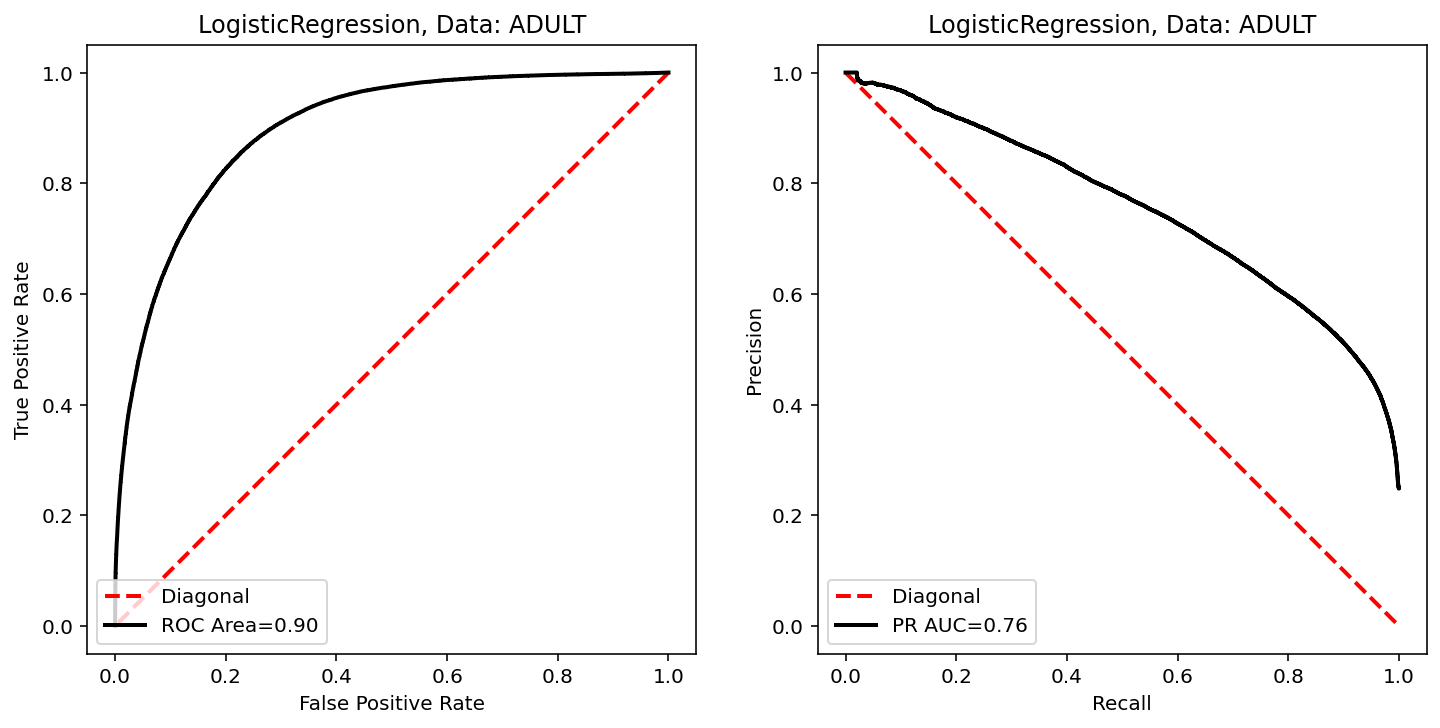

Ended ADULT in 20.868 seconds
Started on LETTER1 dataset


Started trial:  1

Best param for ACC: {'C': 10, 'solver': 'liblinear'}
Ended trial 1 in 0.617 seconds


Started trial:  2

Best param for ACC: {'C': 10, 'solver': 'liblinear'}
Ended trial 2 in 0.648 seconds


Started trial:  3

Best param for ACC: {'C': 10, 'solver': 'liblinear'}
Ended trial 3 in 0.651 seconds


Started trial:  4

Best param for ACC: {'C': 100, 'solver': 'liblinear'}
Ended trial 4 in 0.655 seconds


Started trial:  5

Best param for ACC: {'C': 0.1, 'solver': 'liblinear'}
Ended trial 5 in 0.653 seconds




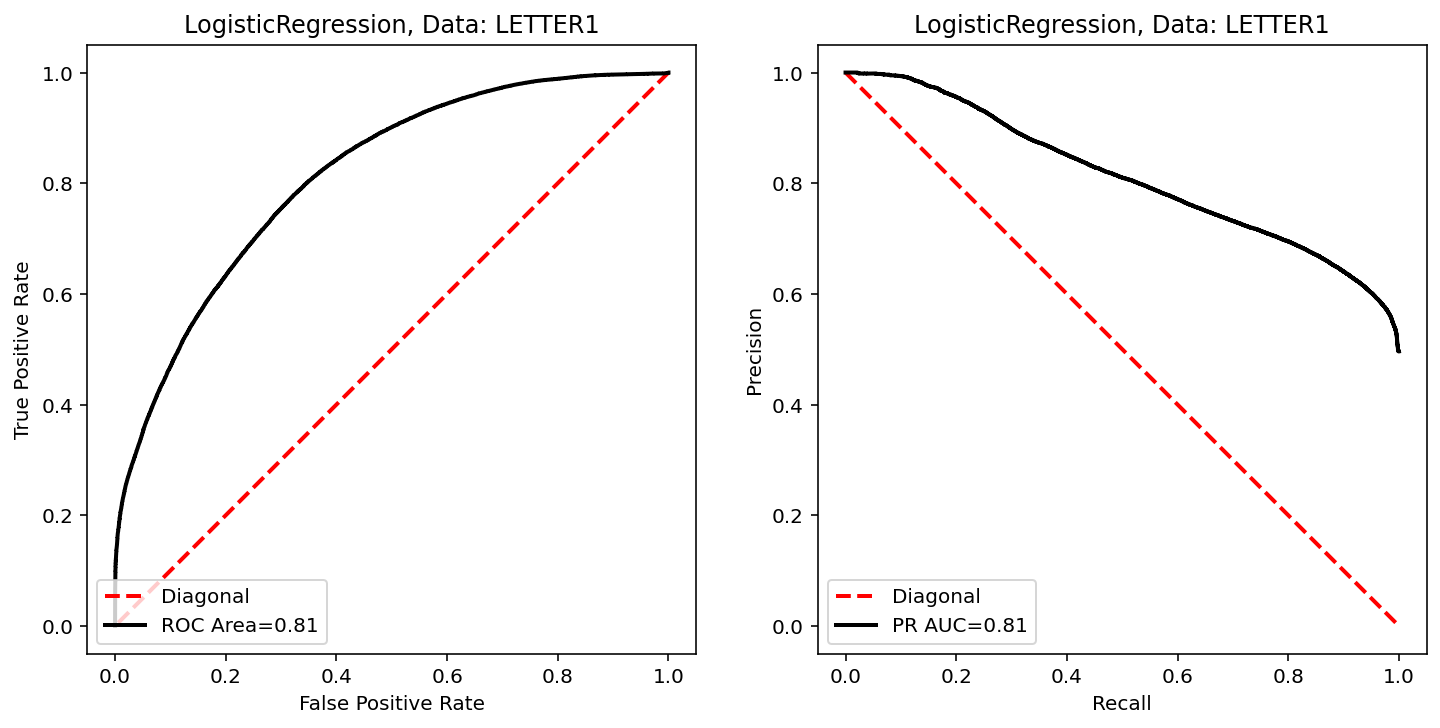

Ended LETTER1 in 4.004 seconds
Started on LETTER2 dataset


Started trial:  1

Best param for ACC: {'C': 1e-08, 'solver': 'liblinear'}
Ended trial 1 in 0.604 seconds


Started trial:  2

Best param for ACC: {'C': 1e-08, 'solver': 'liblinear'}
Ended trial 2 in 0.621 seconds


Started trial:  3

Best param for ACC: {'C': 1e-08, 'solver': 'liblinear'}
Ended trial 3 in 0.623 seconds


Started trial:  4

Best param for ACC: {'C': 1e-08, 'solver': 'liblinear'}
Ended trial 4 in 0.608 seconds


Started trial:  5

Best param for ACC: {'C': 1e-08, 'solver': 'liblinear'}
Ended trial 5 in 0.625 seconds




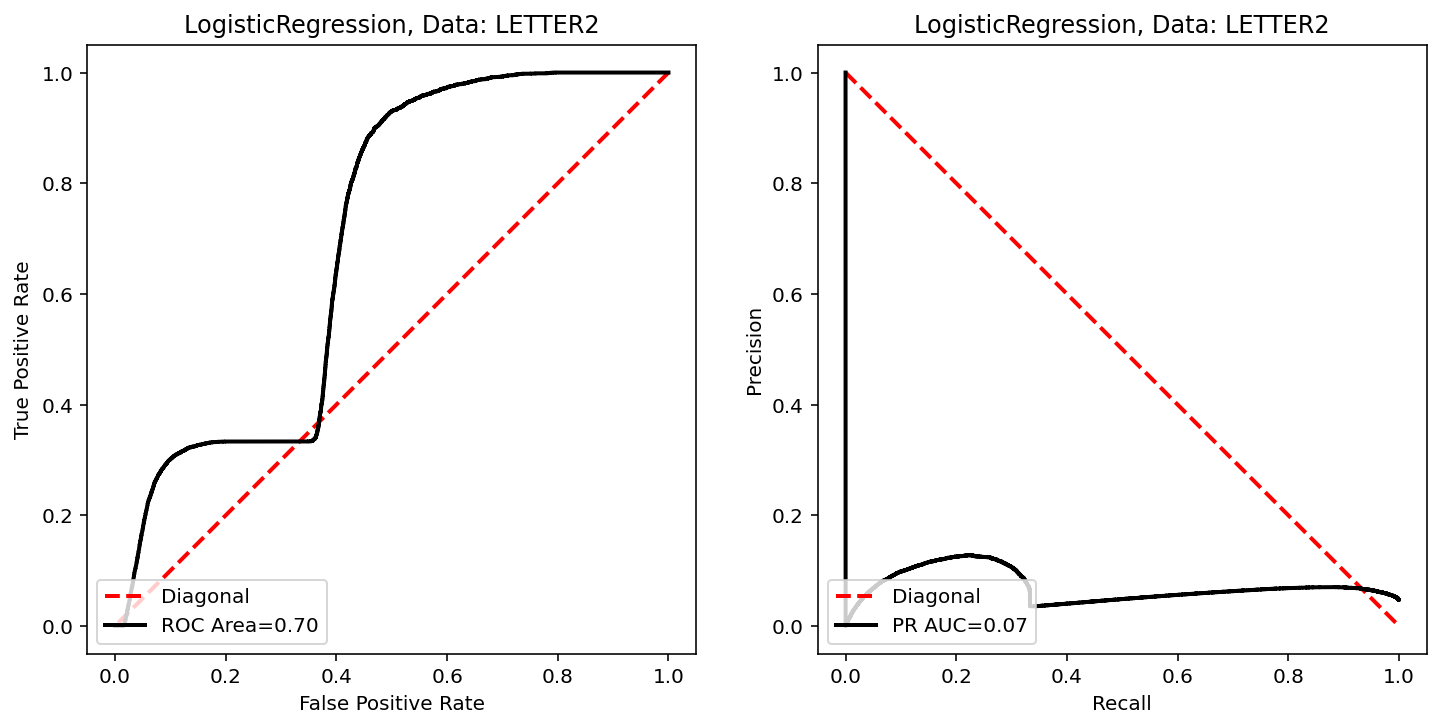

Ended LETTER2 in 3.837 seconds
Started on COVTYPE dataset


Started trial:  1

Best param for ACC: {'C': 0.1, 'solver': 'liblinear'}
Ended trial 1 in 1.753 seconds


Started trial:  2

Best param for ACC: {'C': 1, 'solver': 'liblinear'}
Ended trial 2 in 1.839 seconds


Started trial:  3

Best param for ACC: {'C': 1, 'solver': 'liblinear'}
Ended trial 3 in 1.875 seconds


Started trial:  4

Best param for ACC: {'C': 0.1, 'solver': 'liblinear'}
Ended trial 4 in 1.843 seconds


Started trial:  5

Best param for ACC: {'C': 1, 'solver': 'liblinear'}
Ended trial 5 in 1.842 seconds




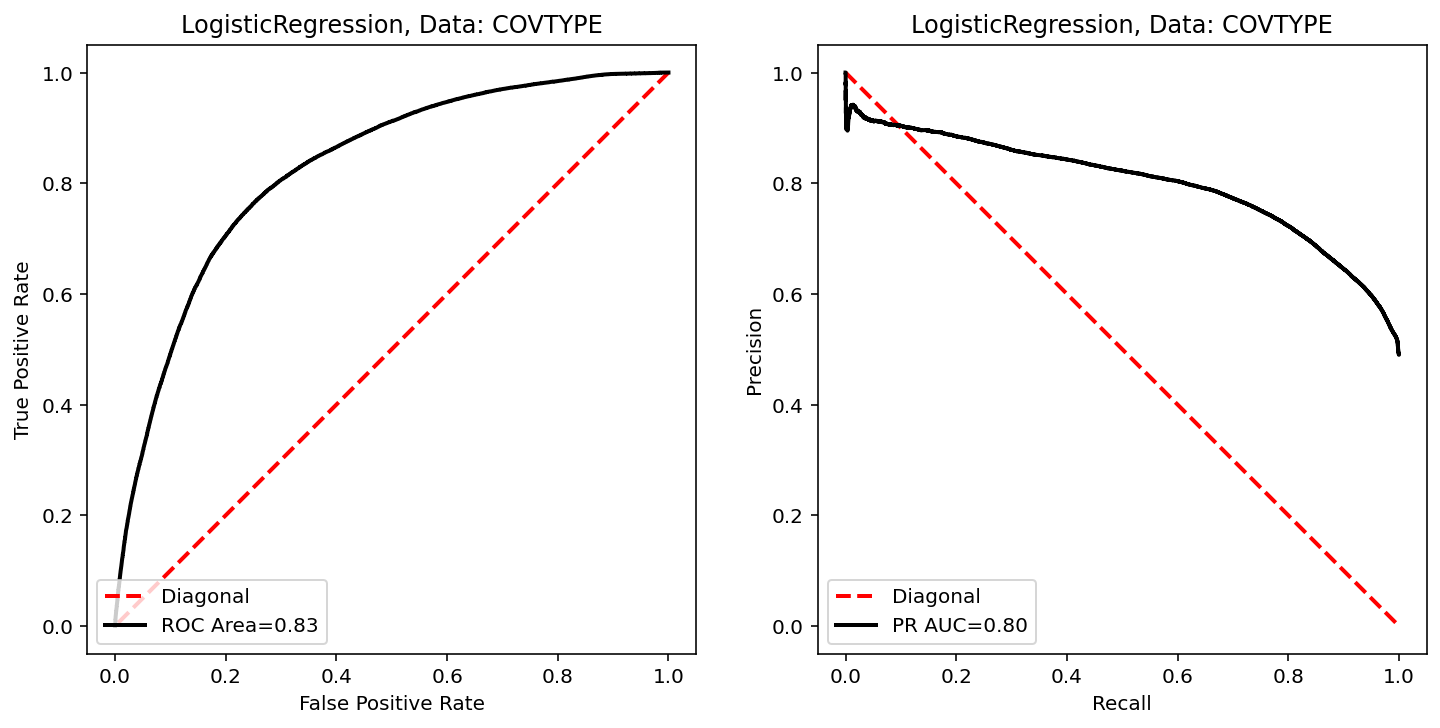

Ended COVTYPE in 10.105 seconds
Ended LogisticRegression() in 38.831 seconds

--------------------------------------------------------------



In [11]:
# algorithms = [LOGIT, TREES, FOREST, GBOOST, MLP_ADAM, NB]
learn(0, algorithms[0])

### Decision Trees


--------------------------------------------------------------

Started training DecisionTreeClassifier()


Started on ADULT dataset


Started trial:  1

Best param for ACC: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 5}
Ended trial 1 in 20.131 seconds


Started trial:  2

Best param for ACC: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 5}
Ended trial 2 in 19.969 seconds


Started trial:  3

Best param for ACC: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}
Ended trial 3 in 19.803 seconds


Started trial:  4

Best param for ACC: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5}
Ended trial 4 in 20.526 seconds


Started trial:  5

Best param for ACC: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 9}
Ended trial 5 in 20.601 seconds




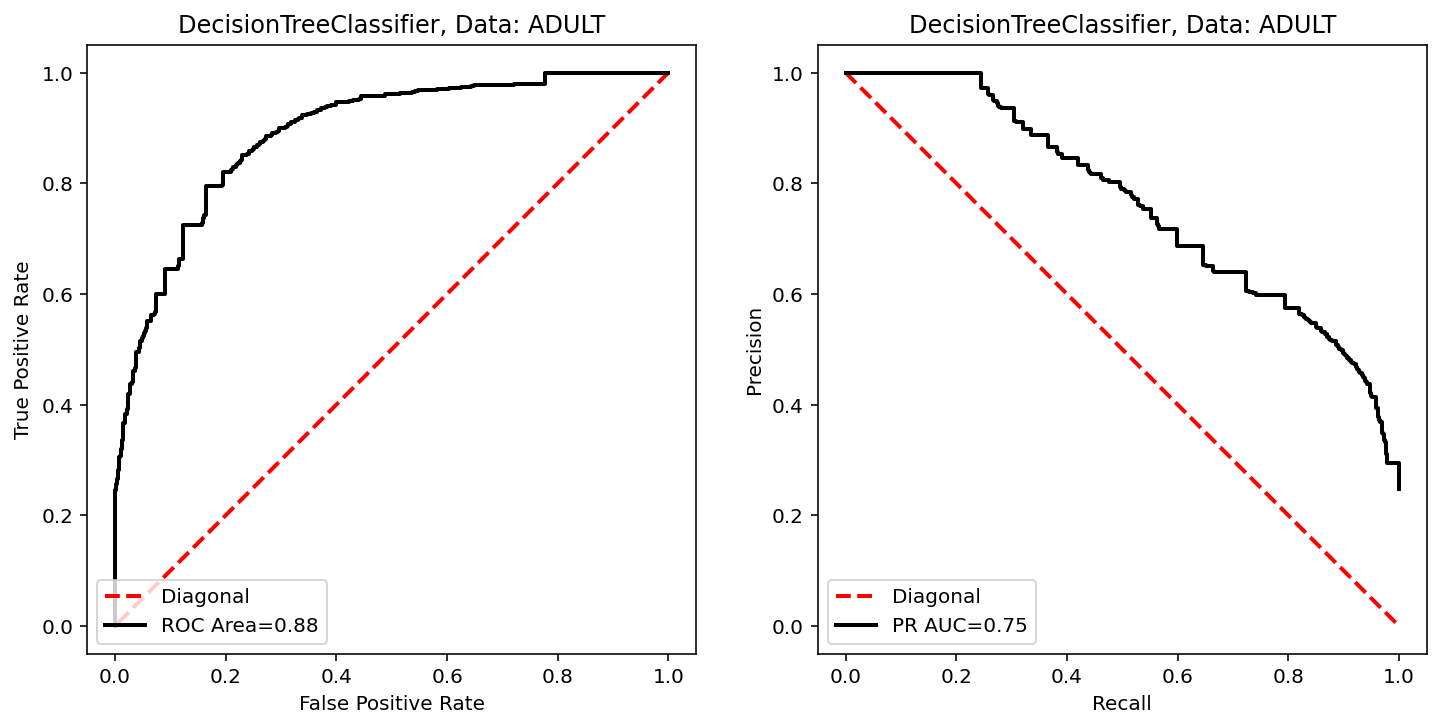

Ended ADULT in 101.847 seconds
Started on LETTER1 dataset


Started trial:  1

Best param for ACC: {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 3}
Ended trial 1 in 11.927 seconds


Started trial:  2

Best param for ACC: {'criterion': 'entropy', 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 3}
Ended trial 2 in 12.102 seconds


Started trial:  3

Best param for ACC: {'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 3}
Ended trial 3 in 11.957 seconds


Started trial:  4

Best param for ACC: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 3}
Ended trial 4 in 12.004 seconds


Started trial:  5

Best param for ACC: {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 5}
Ended trial 5 in 11.884 seconds




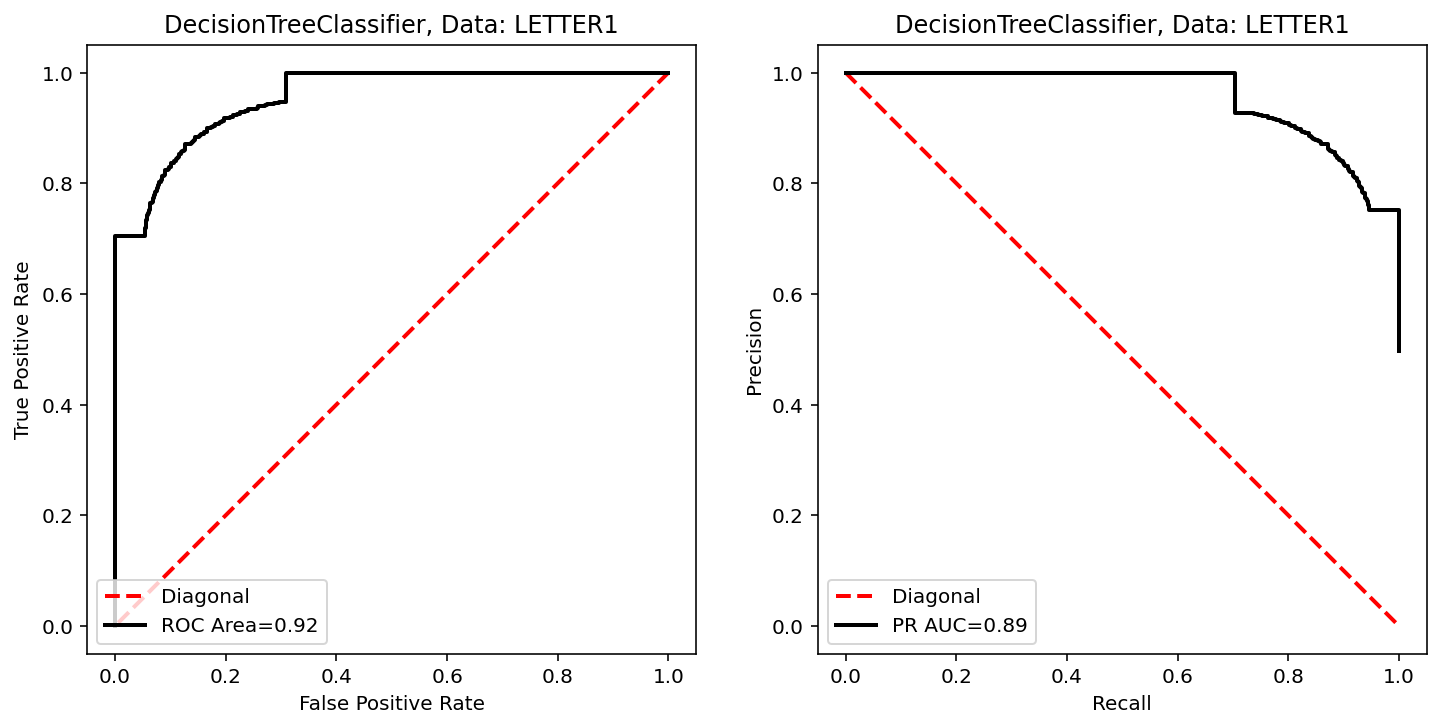

Ended LETTER1 in 60.604 seconds
Started on LETTER2 dataset


Started trial:  1

Best param for ACC: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 9}
Ended trial 1 in 8.374 seconds


Started trial:  2

Best param for ACC: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 9}
Ended trial 2 in 8.583 seconds


Started trial:  3

Best param for ACC: {'criterion': 'entropy', 'max_depth': 22, 'min_samples_leaf': 3, 'min_samples_split': 3}
Ended trial 3 in 8.465 seconds


Started trial:  4

Best param for ACC: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 7}
Ended trial 4 in 8.291 seconds


Started trial:  5

Best param for ACC: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 5, 'min_samples_split': 3}
Ended trial 5 in 8.218 seconds




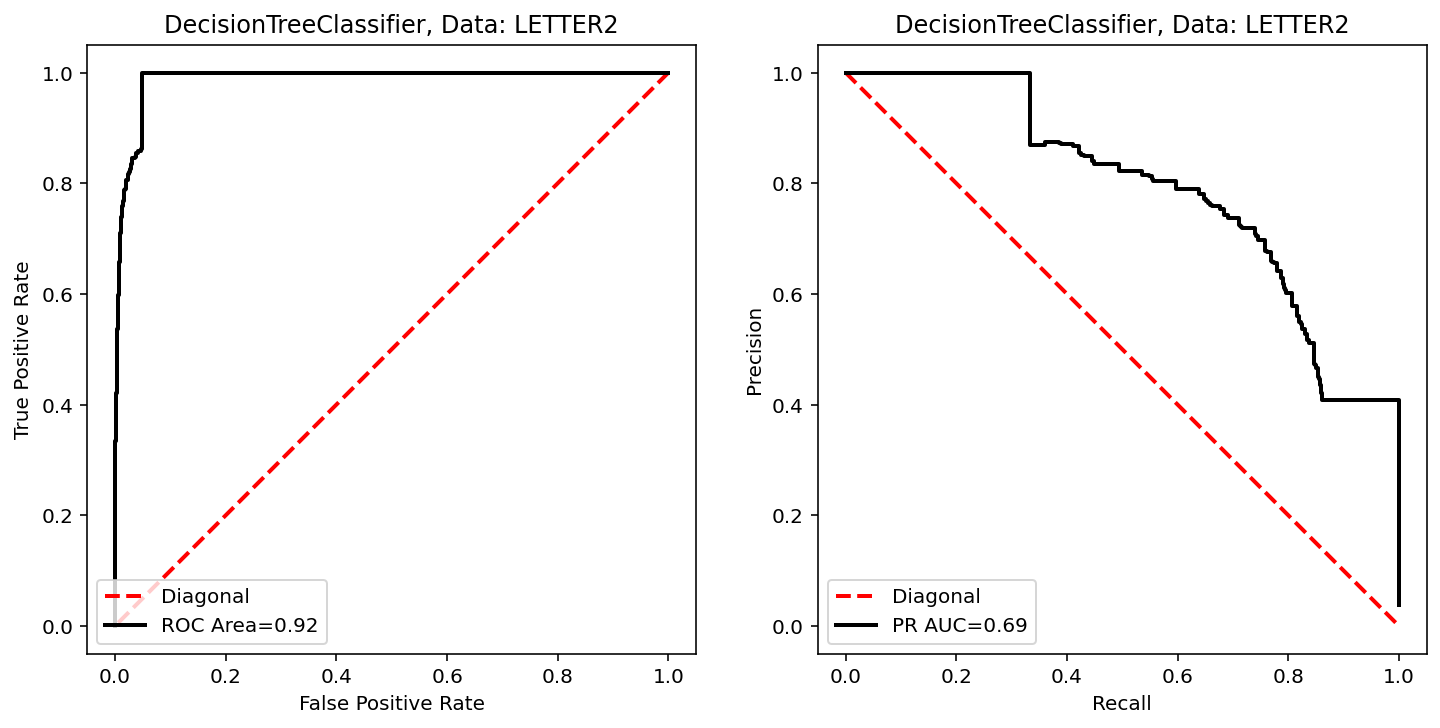

Ended LETTER2 in 42.496 seconds
Started on COVTYPE dataset


Started trial:  1

Best param for ACC: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5}
Ended trial 1 in 26.565 seconds


Started trial:  2

Best param for ACC: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}
Ended trial 2 in 26.703 seconds


Started trial:  3

Best param for ACC: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}
Ended trial 3 in 26.336 seconds


Started trial:  4

Best param for ACC: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 3}
Ended trial 4 in 26.174 seconds


Started trial:  5

Best param for ACC: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 7}
Ended trial 5 in 26.372 seconds




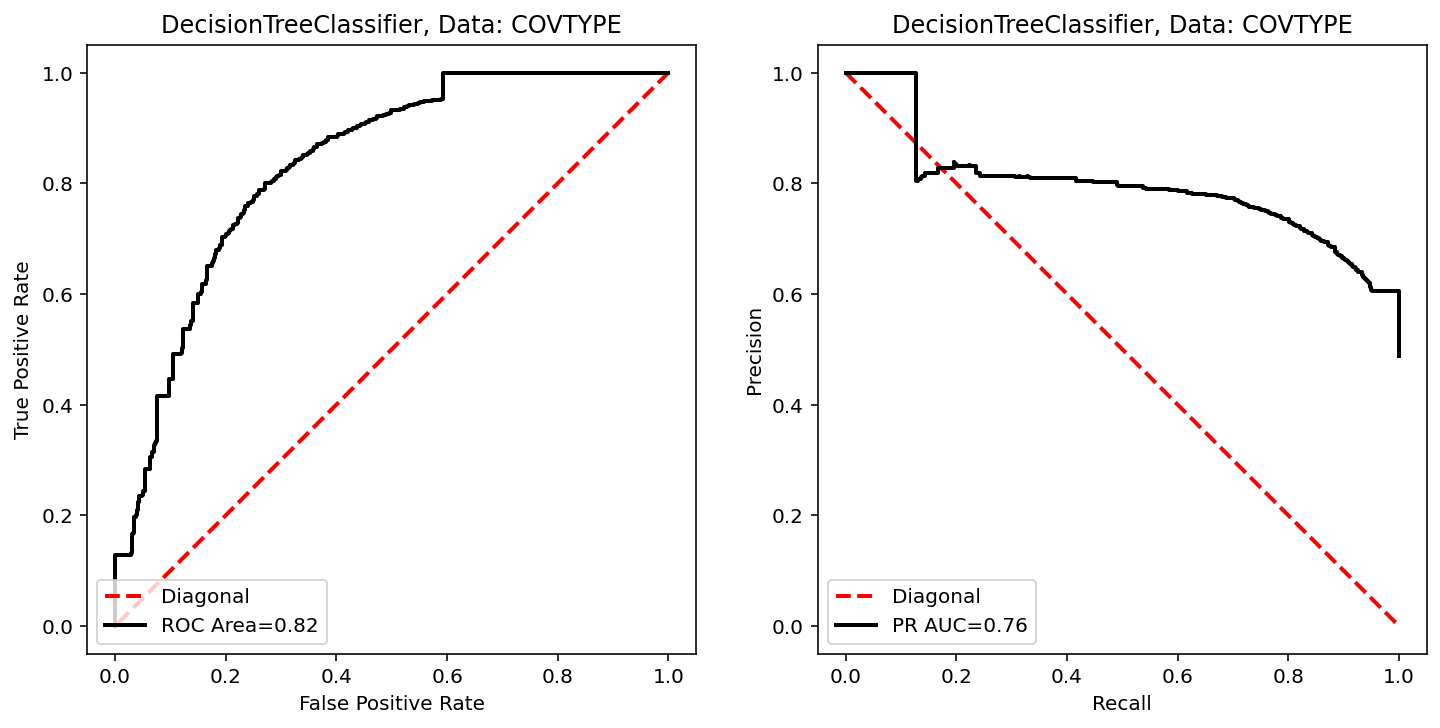

Ended COVTYPE in 132.865 seconds
Ended DecisionTreeClassifier() in 337.838 seconds

--------------------------------------------------------------



In [12]:
# algorithms = [LOGIT, TREES, FOREST, GBOOST, MLP_ADAM, NB]
learn(1, algorithms[1])

### Random Forest


--------------------------------------------------------------

Started training RandomForestClassifier()


Started on ADULT dataset


Started trial:  1

Best param for ACC: {'max_features': 20, 'n_estimators': 128}
Ended trial 1 in 286.844 seconds


Started trial:  2

Best param for ACC: {'max_features': 20, 'n_estimators': 64}
Ended trial 2 in 285.805 seconds


Started trial:  3

Best param for ACC: {'max_features': 12, 'n_estimators': 1024}
Ended trial 3 in 291.114 seconds


Started trial:  4

Best param for ACC: {'max_features': 20, 'n_estimators': 128}
Ended trial 4 in 271.292 seconds


Started trial:  5

Best param for ACC: {'max_features': 20, 'n_estimators': 512}
Ended trial 5 in 269.076 seconds




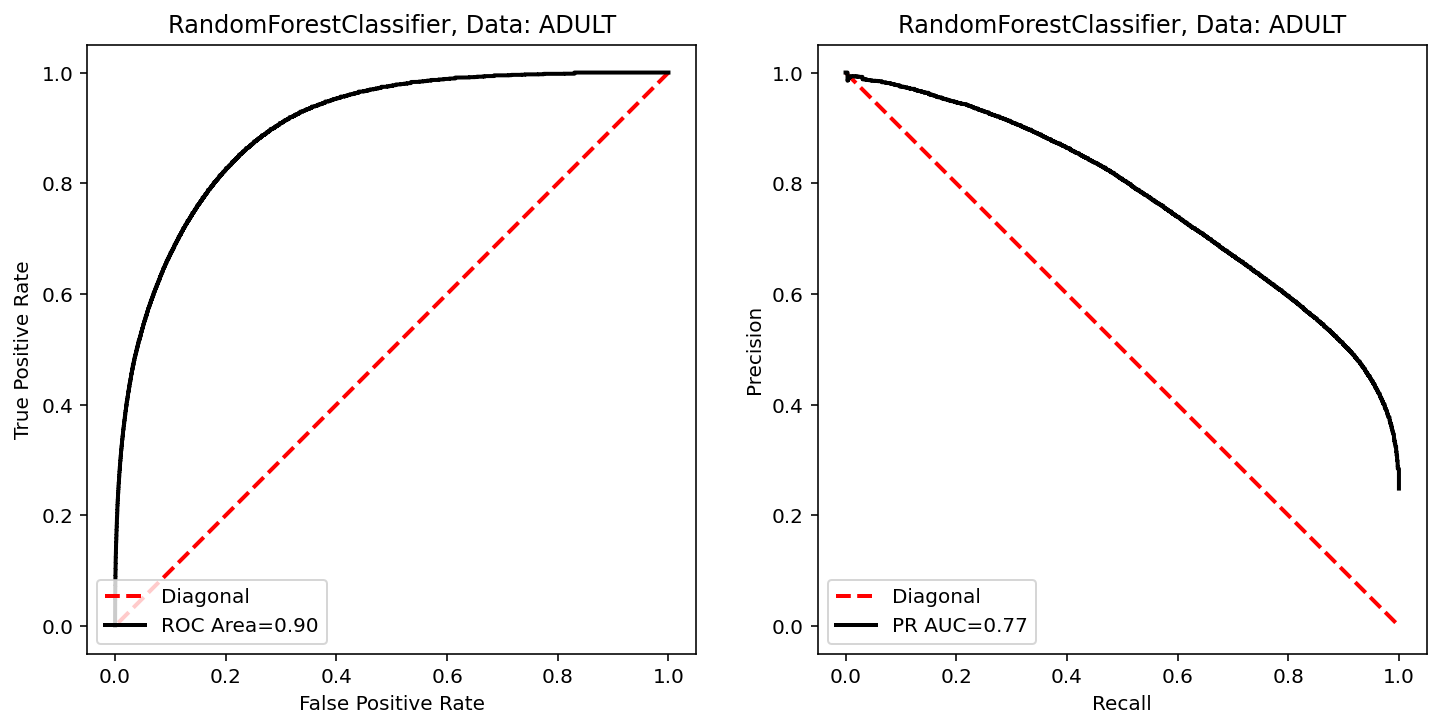

Ended ADULT in 1405.019 seconds
Started on LETTER1 dataset


Started trial:  1

Best param for ACC: {'max_features': 6, 'n_estimators': 256}
Ended trial 1 in 244.759 seconds


Started trial:  2

Best param for ACC: {'max_features': 6, 'n_estimators': 1024}
Ended trial 2 in 271.934 seconds


Started trial:  3

Best param for ACC: {'max_features': 4, 'n_estimators': 128}
Ended trial 3 in 254.143 seconds


Started trial:  4

Best param for ACC: {'max_features': 6, 'n_estimators': 256}
Ended trial 4 in 258.065 seconds


Started trial:  5

Best param for ACC: {'max_features': 8, 'n_estimators': 1024}
Ended trial 5 in 276.614 seconds




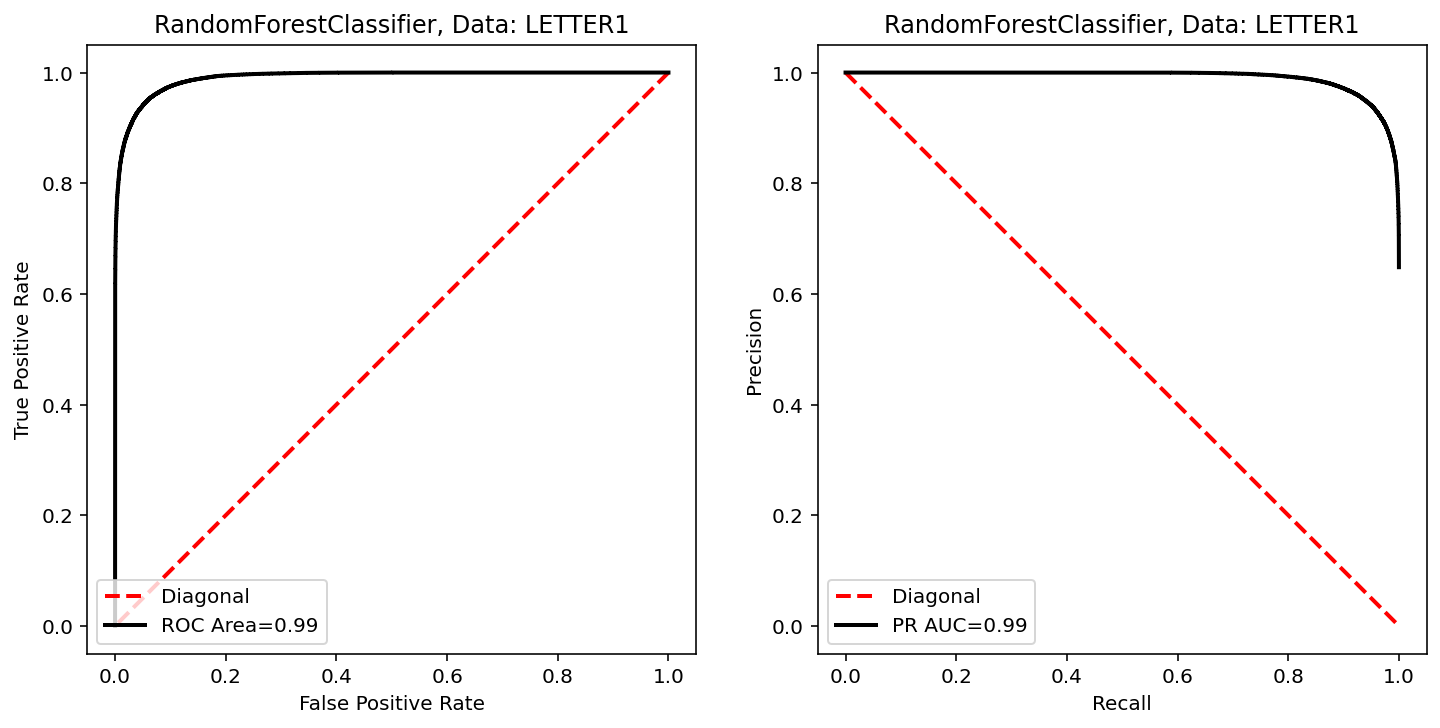

Ended LETTER1 in 1306.155 seconds
Started on LETTER2 dataset


Started trial:  1

Best param for ACC: {'max_features': 4, 'n_estimators': 256}
Ended trial 1 in 149.689 seconds


Started trial:  2

Best param for ACC: {'max_features': 6, 'n_estimators': 64}
Ended trial 2 in 149.069 seconds


Started trial:  3

Best param for ACC: {'max_features': 12, 'n_estimators': 256}
Ended trial 3 in 155.357 seconds


Started trial:  4

Best param for ACC: {'max_features': 4, 'n_estimators': 128}
Ended trial 4 in 152.603 seconds


Started trial:  5

Best param for ACC: {'max_features': 6, 'n_estimators': 128}
Ended trial 5 in 150.665 seconds




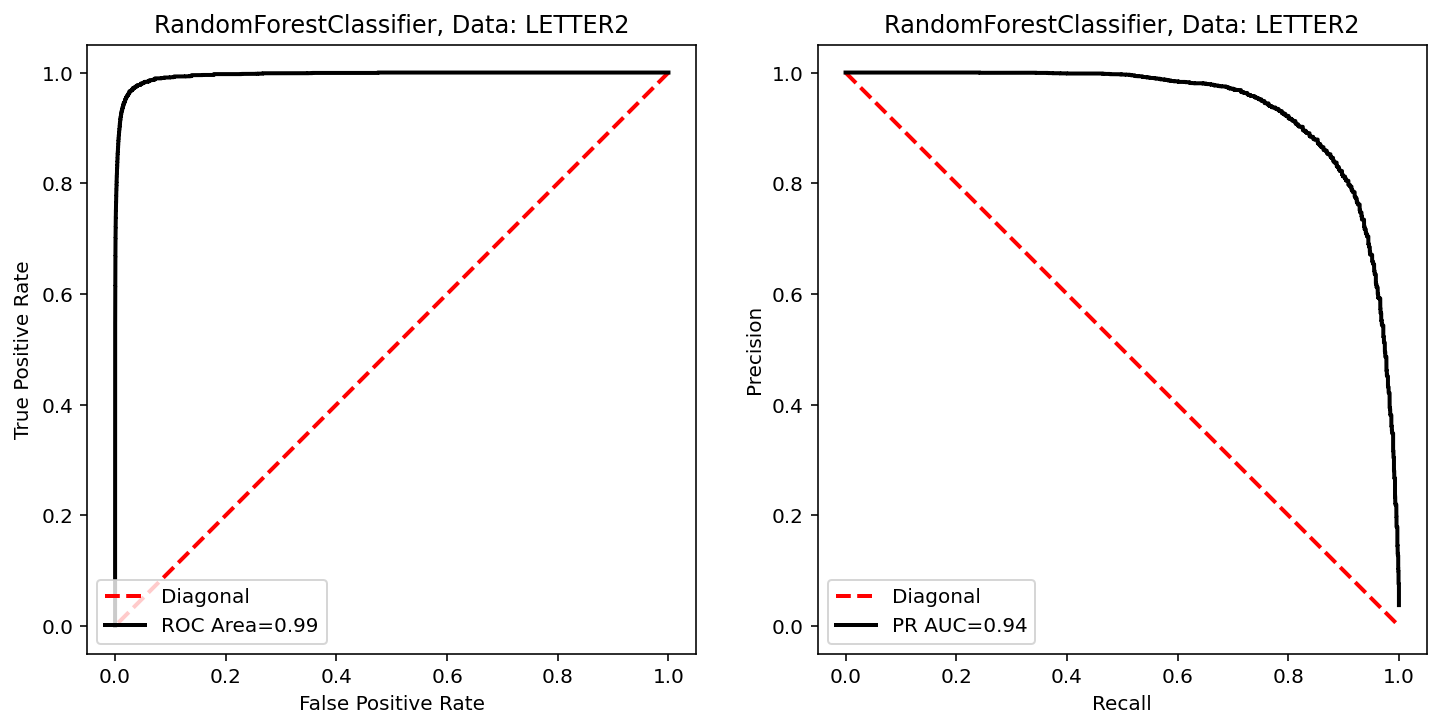

Ended LETTER2 in 758.092 seconds
Started on COVTYPE dataset


Started trial:  1

Best param for ACC: {'max_features': 16, 'n_estimators': 1024}
Ended trial 1 in 402.580 seconds


Started trial:  2

Best param for ACC: {'max_features': 20, 'n_estimators': 1024}
Ended trial 2 in 399.930 seconds


Started trial:  3

Best param for ACC: {'max_features': 20, 'n_estimators': 512}
Ended trial 3 in 377.385 seconds


Started trial:  4

Best param for ACC: {'max_features': 8, 'n_estimators': 256}
Ended trial 4 in 352.064 seconds


Started trial:  5

Best param for ACC: {'max_features': 16, 'n_estimators': 256}
Ended trial 5 in 368.831 seconds




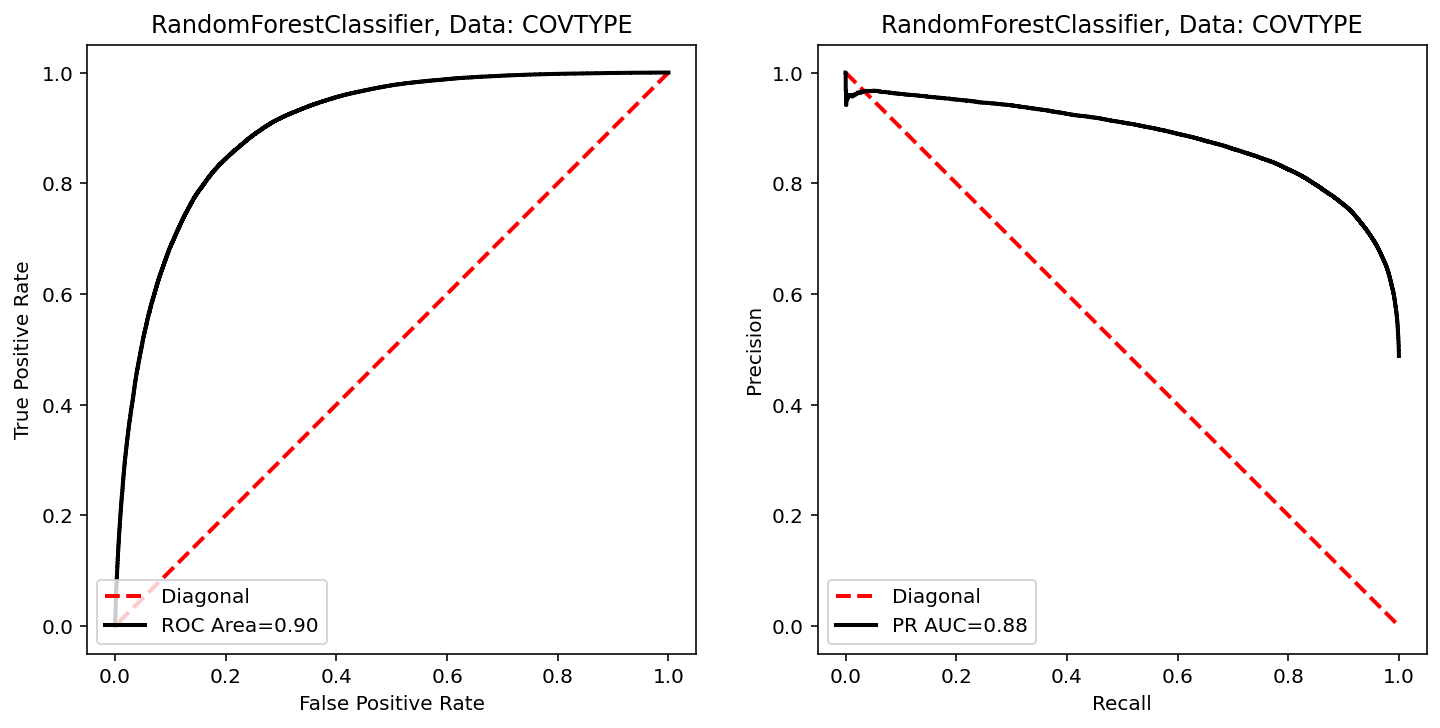

Ended COVTYPE in 1901.574 seconds
Ended RandomForestClassifier() in 5370.861 seconds

--------------------------------------------------------------



In [13]:
# algorithms = [LOGIT, TREES, FOREST, GBOOST, MLP_ADAM, NB]
learn(2, algorithms[2])

### Gradient Boosting Classifier


--------------------------------------------------------------

Started training GradientBoostingClassifier()


Started on ADULT dataset


Started trial:  1

Best param for ACC: {'max_depth': 5, 'n_estimators': 64}
Ended trial 1 in 555.608 seconds


Started trial:  2

Best param for ACC: {'max_depth': 5, 'n_estimators': 64}
Ended trial 2 in 569.279 seconds


Started trial:  3

Best param for ACC: {'max_depth': 3, 'n_estimators': 256}
Ended trial 3 in 555.706 seconds


Started trial:  4

Best param for ACC: {'max_depth': 5, 'n_estimators': 128}
Ended trial 4 in 564.763 seconds


Started trial:  5

Best param for ACC: {'max_depth': 5, 'n_estimators': 128}
Ended trial 5 in 613.525 seconds




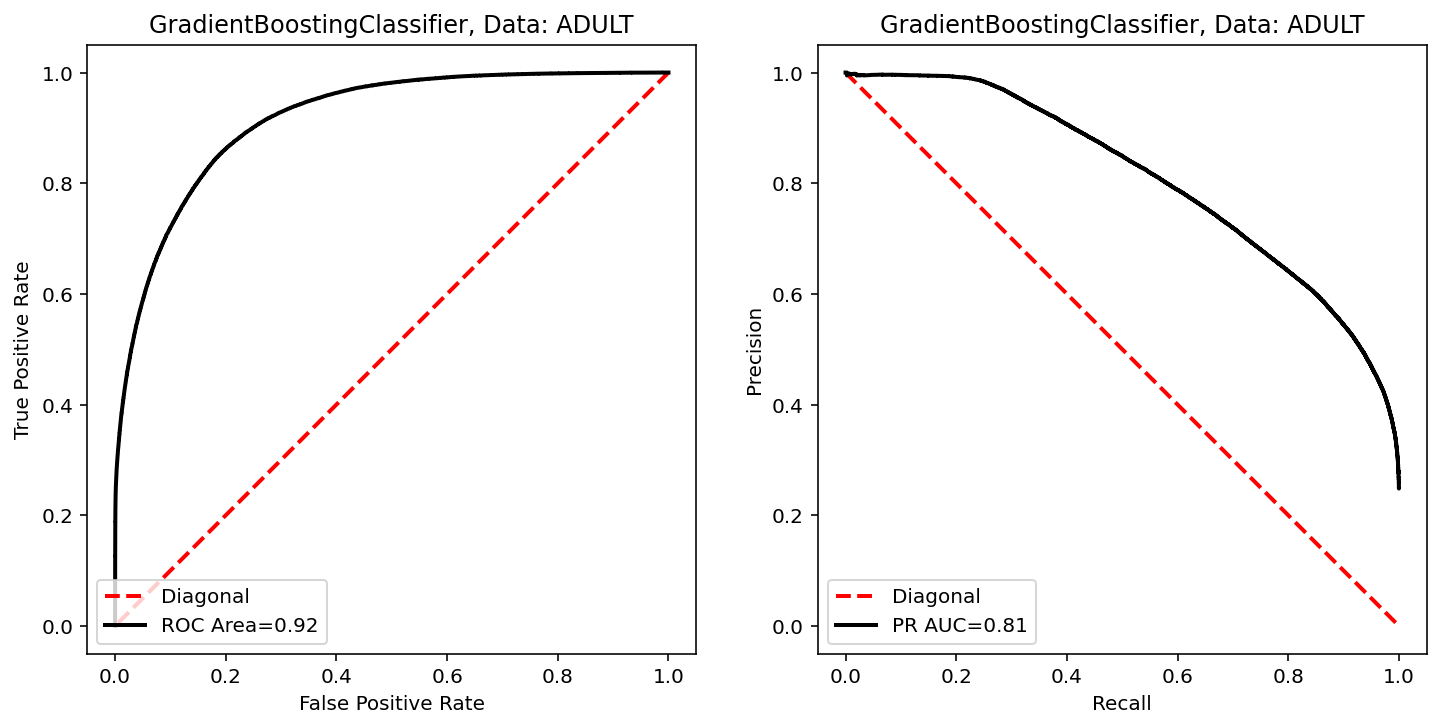

Ended ADULT in 2860.047 seconds
Started on LETTER1 dataset


Started trial:  1

Best param for ACC: {'max_depth': 7, 'n_estimators': 2048}
Ended trial 1 in 300.566 seconds


Started trial:  2

Best param for ACC: {'max_depth': 7, 'n_estimators': 2048}
Ended trial 2 in 304.199 seconds


Started trial:  3

Best param for ACC: {'max_depth': 7, 'n_estimators': 2048}
Ended trial 3 in 301.019 seconds


Started trial:  4

Best param for ACC: {'max_depth': 7, 'n_estimators': 1024}
Ended trial 4 in 304.136 seconds


Started trial:  5

Best param for ACC: {'max_depth': 9, 'n_estimators': 2048}
Ended trial 5 in 297.712 seconds




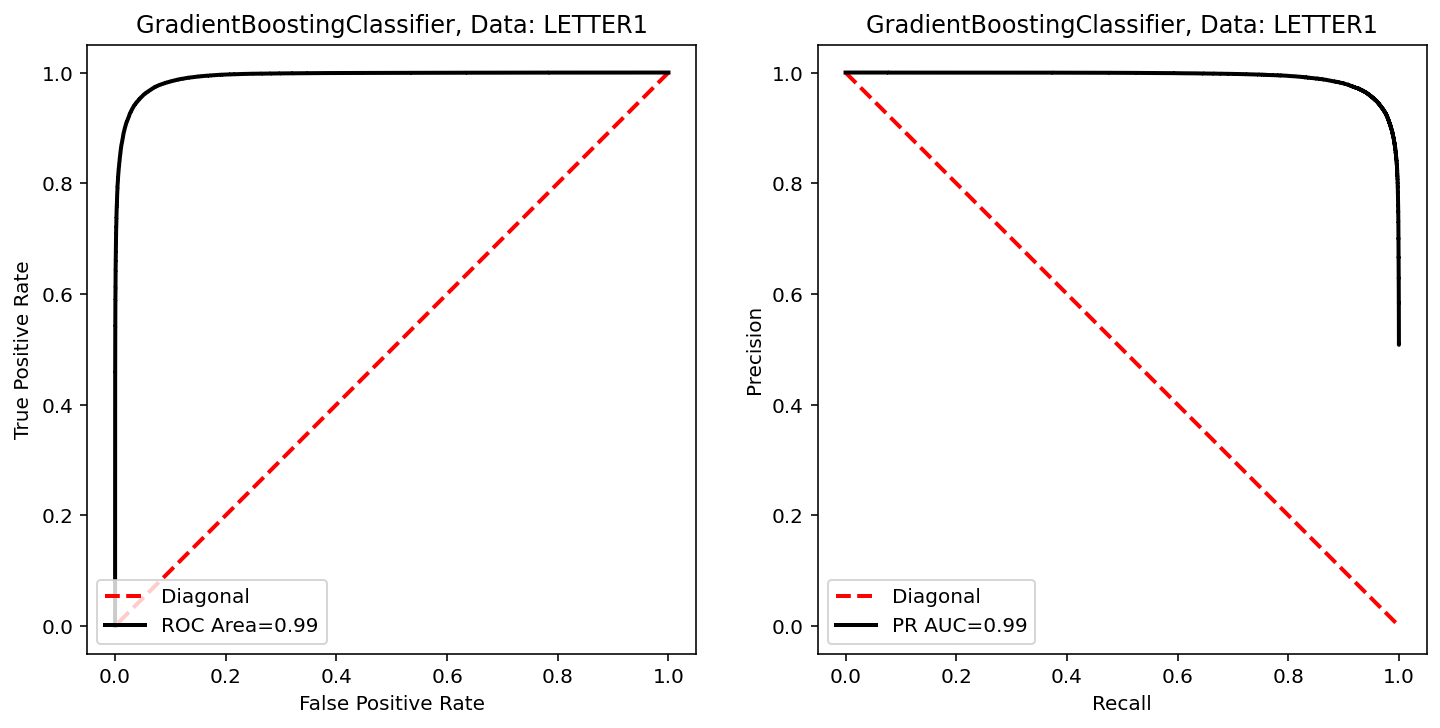

Ended LETTER1 in 1508.383 seconds
Started on LETTER2 dataset


Started trial:  1

Best param for ACC: {'max_depth': 3, 'n_estimators': 2048}
Ended trial 1 in 176.132 seconds


Started trial:  2

Best param for ACC: {'max_depth': 3, 'n_estimators': 2048}
Ended trial 2 in 175.810 seconds


Started trial:  3

Best param for ACC: {'max_depth': 3, 'n_estimators': 1024}
Ended trial 3 in 165.846 seconds


Started trial:  4

Best param for ACC: {'max_depth': 3, 'n_estimators': 1024}
Ended trial 4 in 167.593 seconds


Started trial:  5

Best param for ACC: {'max_depth': 3, 'n_estimators': 2048}
Ended trial 5 in 194.921 seconds




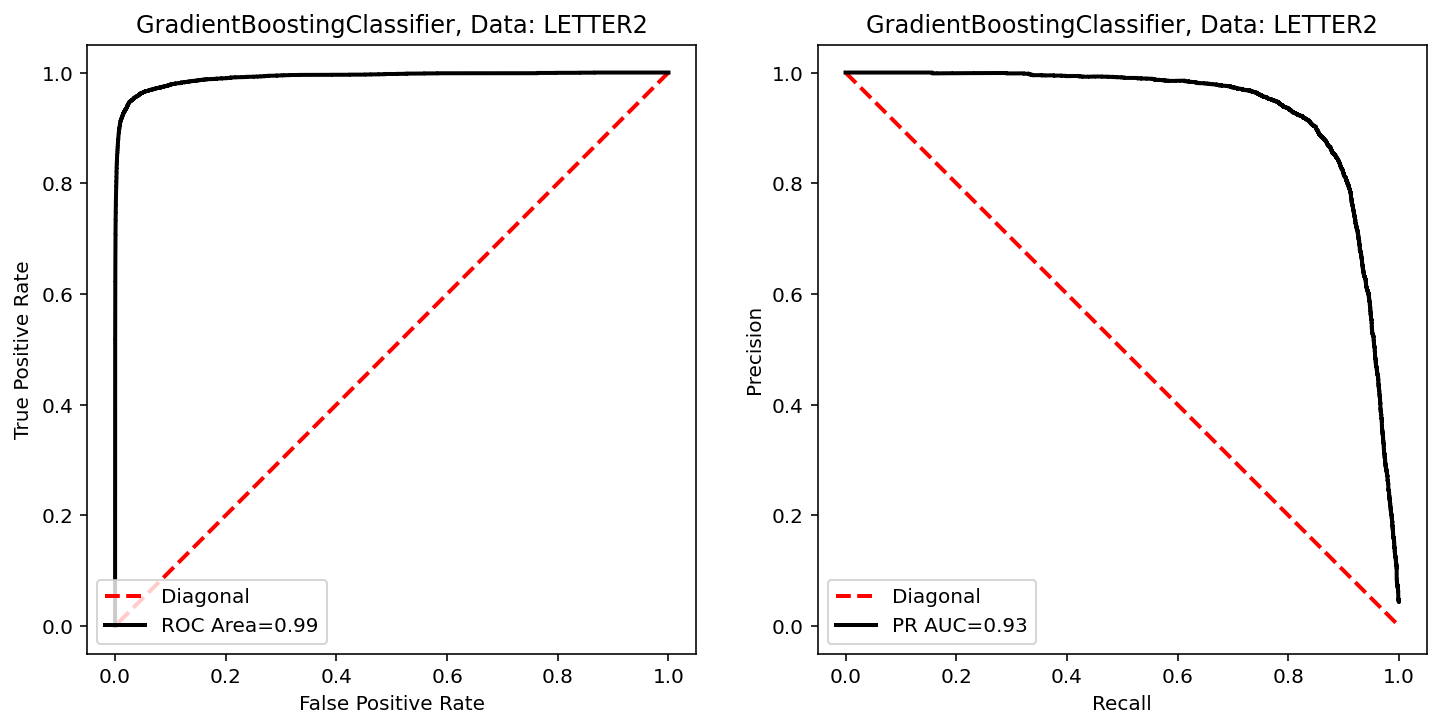

Ended LETTER2 in 881.022 seconds
Started on COVTYPE dataset


Started trial:  1

Best param for ACC: {'max_depth': 9, 'n_estimators': 256}
Ended trial 1 in 668.377 seconds


Started trial:  2

Best param for ACC: {'max_depth': 9, 'n_estimators': 256}
Ended trial 2 in 726.009 seconds


Started trial:  3

Best param for ACC: {'max_depth': 9, 'n_estimators': 2048}
Ended trial 3 in 773.635 seconds


Started trial:  4

Best param for ACC: {'max_depth': 9, 'n_estimators': 2048}
Ended trial 4 in 775.628 seconds


Started trial:  5

Best param for ACC: {'max_depth': 9, 'n_estimators': 512}
Ended trial 5 in 719.997 seconds




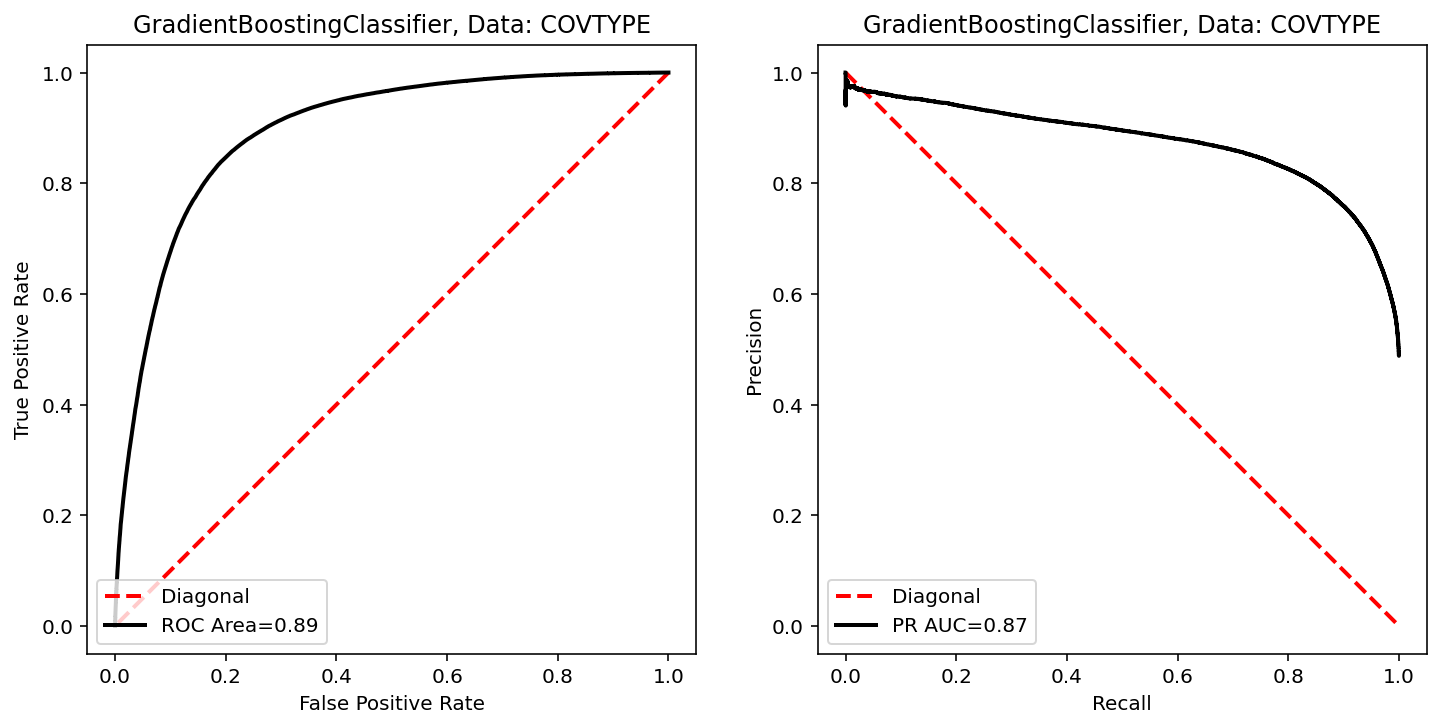

Ended COVTYPE in 3664.564 seconds
Ended GradientBoostingClassifier() in 8914.040 seconds

--------------------------------------------------------------



In [14]:
# algorithms = [LOGIT, TREES, FOREST, GBOOST, MLP_ADAM, NB]
learn(3, algorithms[3])

### MLP with ADAM 


--------------------------------------------------------------

Started training MLPClassifier()


Started on ADULT dataset


Started trial:  1

Best param for ACC: {'hidden_layer_sizes': 2}
Ended trial 1 in 68.496 seconds


Started trial:  2

Best param for ACC: {'hidden_layer_sizes': 2}
Ended trial 2 in 67.534 seconds


Started trial:  3

Best param for ACC: {'hidden_layer_sizes': 2}
Ended trial 3 in 67.870 seconds


Started trial:  4

Best param for ACC: {'hidden_layer_sizes': 2}
Ended trial 4 in 67.869 seconds


Started trial:  5

Best param for ACC: {'hidden_layer_sizes': 2}
Ended trial 5 in 68.193 seconds




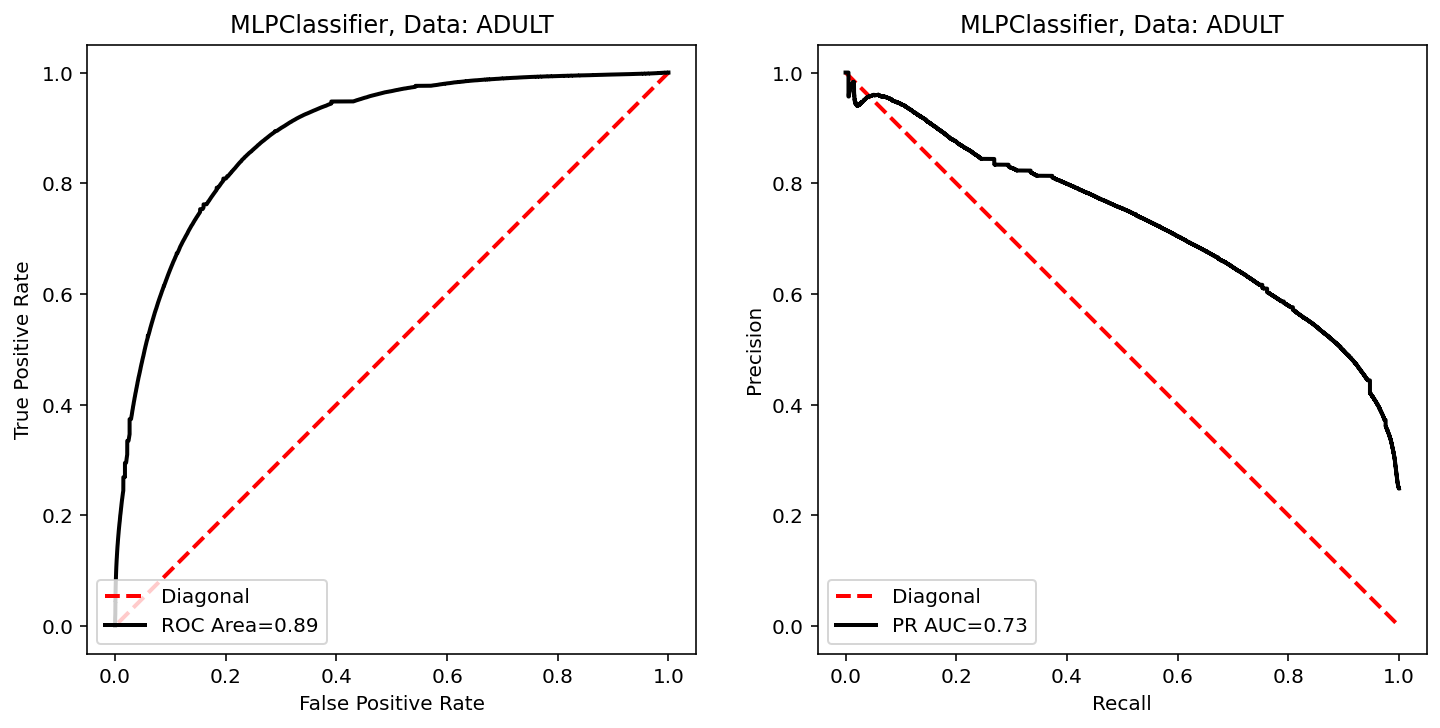

Ended ADULT in 341.140 seconds
Started on LETTER1 dataset


Started trial:  1

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 1 in 82.921 seconds


Started trial:  2

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 2 in 83.131 seconds


Started trial:  3

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 3 in 83.072 seconds


Started trial:  4

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 4 in 83.825 seconds


Started trial:  5

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 5 in 84.096 seconds




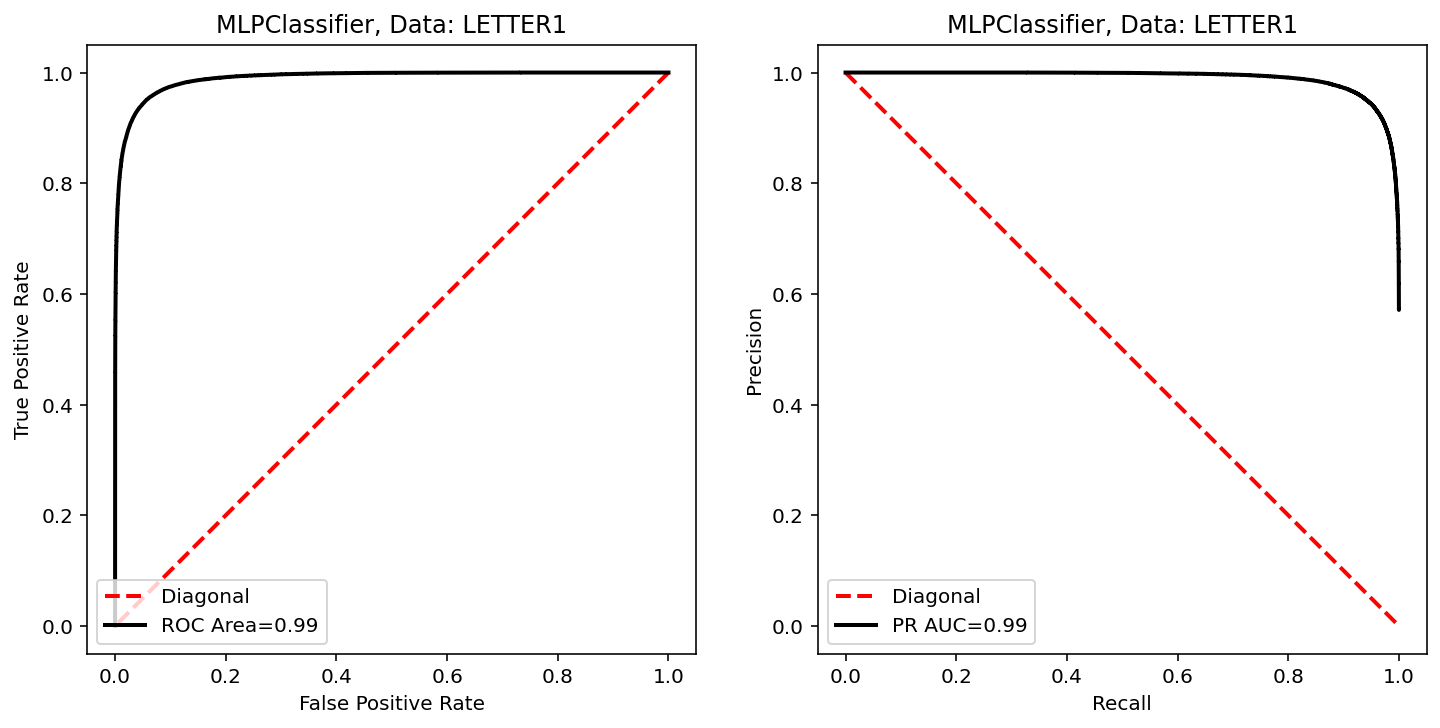

Ended LETTER1 in 417.832 seconds
Started on LETTER2 dataset


Started trial:  1

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 1 in 70.208 seconds


Started trial:  2

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 2 in 66.050 seconds


Started trial:  3

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 3 in 68.206 seconds


Started trial:  4

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 4 in 71.027 seconds


Started trial:  5

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 5 in 69.323 seconds




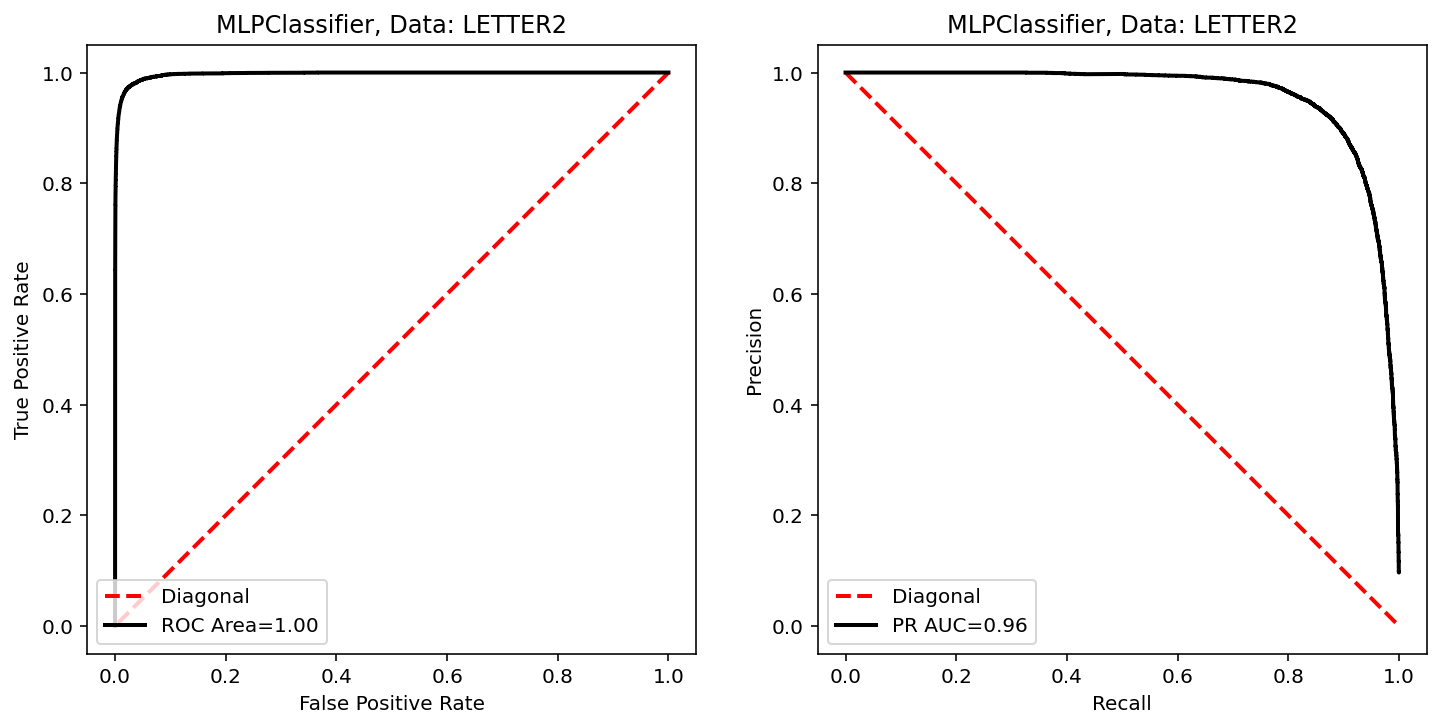

Ended LETTER2 in 345.543 seconds
Started on COVTYPE dataset


Started trial:  1

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 1 in 101.824 seconds


Started trial:  2

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 2 in 101.557 seconds


Started trial:  3

Best param for ACC: {'hidden_layer_sizes': 256}
Ended trial 3 in 96.713 seconds


Started trial:  4

Best param for ACC: {'hidden_layer_sizes': 128}
Ended trial 4 in 86.254 seconds


Started trial:  5

Best param for ACC: {'hidden_layer_sizes': 128}
Ended trial 5 in 89.936 seconds




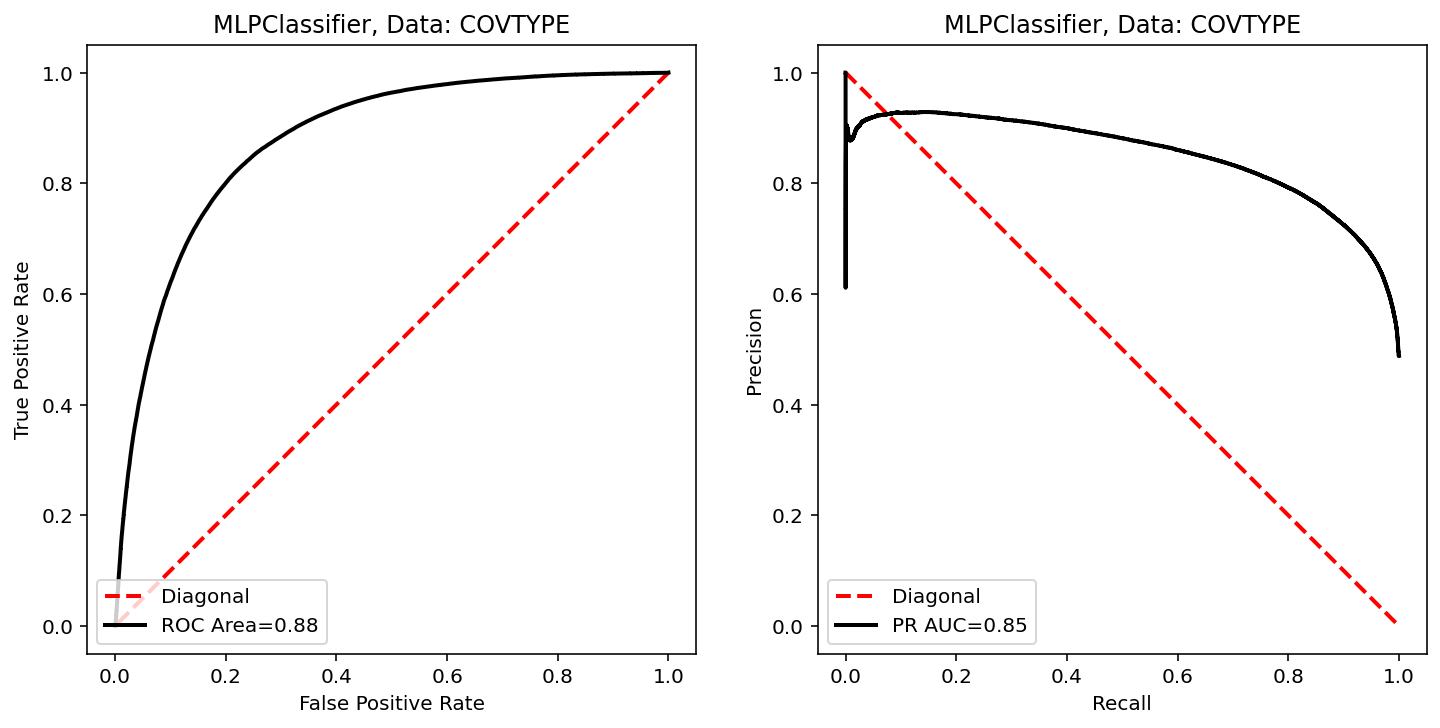

Ended COVTYPE in 477.274 seconds
Ended MLPClassifier() in 1581.808 seconds

--------------------------------------------------------------



In [15]:
# algorithms = [LOGIT, TREES, FOREST, GBOOST, MLP_ADAM, NB]
learn(4, algorithms[4])

### Naive Bayes


--------------------------------------------------------------

Started training BernoulliNB()


Started on ADULT dataset


Started trial:  1

Best param for ACC: {'alpha': 100}
Ended trial 1 in 2.809 seconds


Started trial:  2

Best param for ACC: {'alpha': 100}
Ended trial 2 in 1.639 seconds


Started trial:  3

Best param for ACC: {'alpha': 100}
Ended trial 3 in 1.596 seconds


Started trial:  4

Best param for ACC: {'alpha': 100}
Ended trial 4 in 1.625 seconds


Started trial:  5

Best param for ACC: {'alpha': 100}
Ended trial 5 in 1.591 seconds




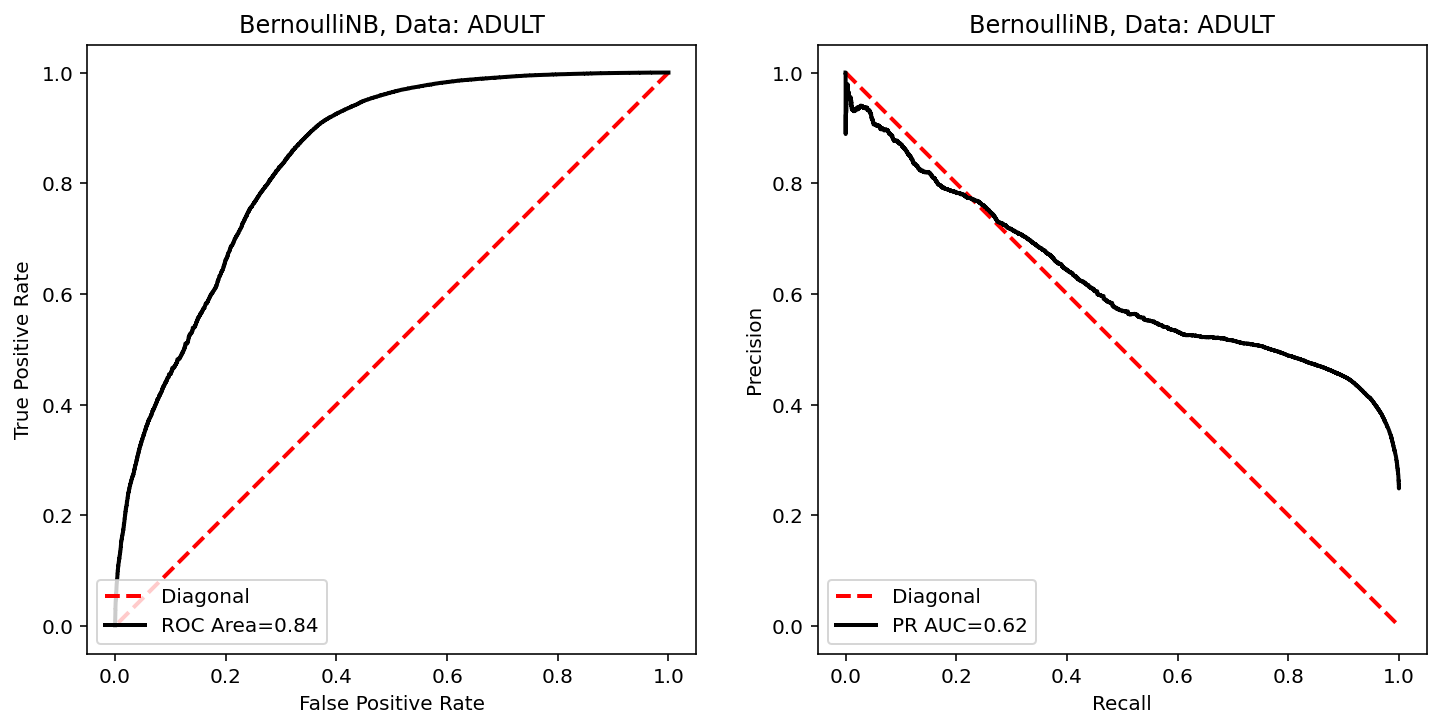

Ended ADULT in 10.454 seconds
Started on LETTER1 dataset


Started trial:  1

Best param for ACC: {'alpha': 0.0001}
Ended trial 1 in 0.428 seconds


Started trial:  2

Best param for ACC: {'alpha': 0.0001}
Ended trial 2 in 0.432 seconds


Started trial:  3

Best param for ACC: {'alpha': 100}
Ended trial 3 in 0.408 seconds


Started trial:  4

Best param for ACC: {'alpha': 100}
Ended trial 4 in 0.405 seconds


Started trial:  5

Best param for ACC: {'alpha': 10}
Ended trial 5 in 0.427 seconds




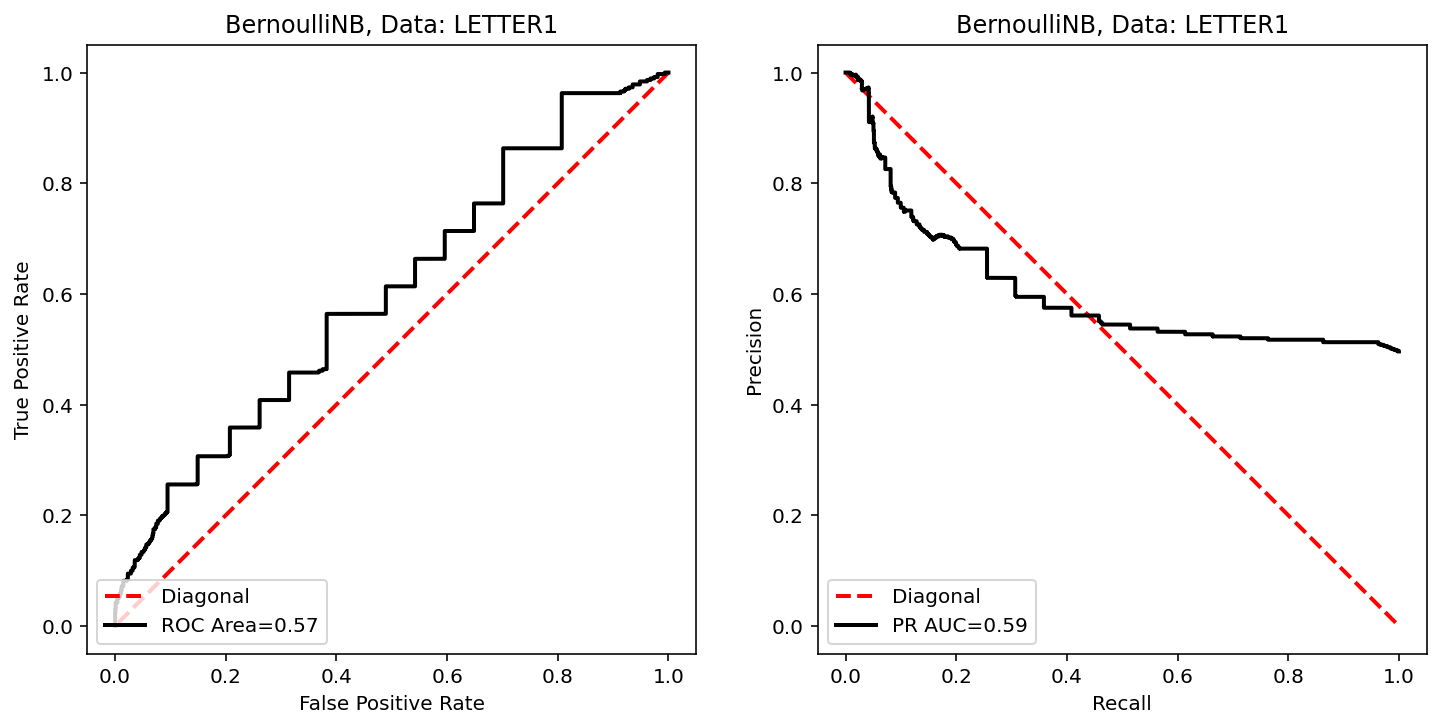

Ended LETTER1 in 2.778 seconds
Started on LETTER2 dataset


Started trial:  1

Best param for ACC: {'alpha': 0.0001}
Ended trial 1 in 0.413 seconds


Started trial:  2

Best param for ACC: {'alpha': 1000}
Ended trial 2 in 0.404 seconds


Started trial:  3

Best param for ACC: {'alpha': 1000}
Ended trial 3 in 0.422 seconds


Started trial:  4

Best param for ACC: {'alpha': 0.0001}
Ended trial 4 in 0.427 seconds


Started trial:  5

Best param for ACC: {'alpha': 1000}
Ended trial 5 in 0.416 seconds




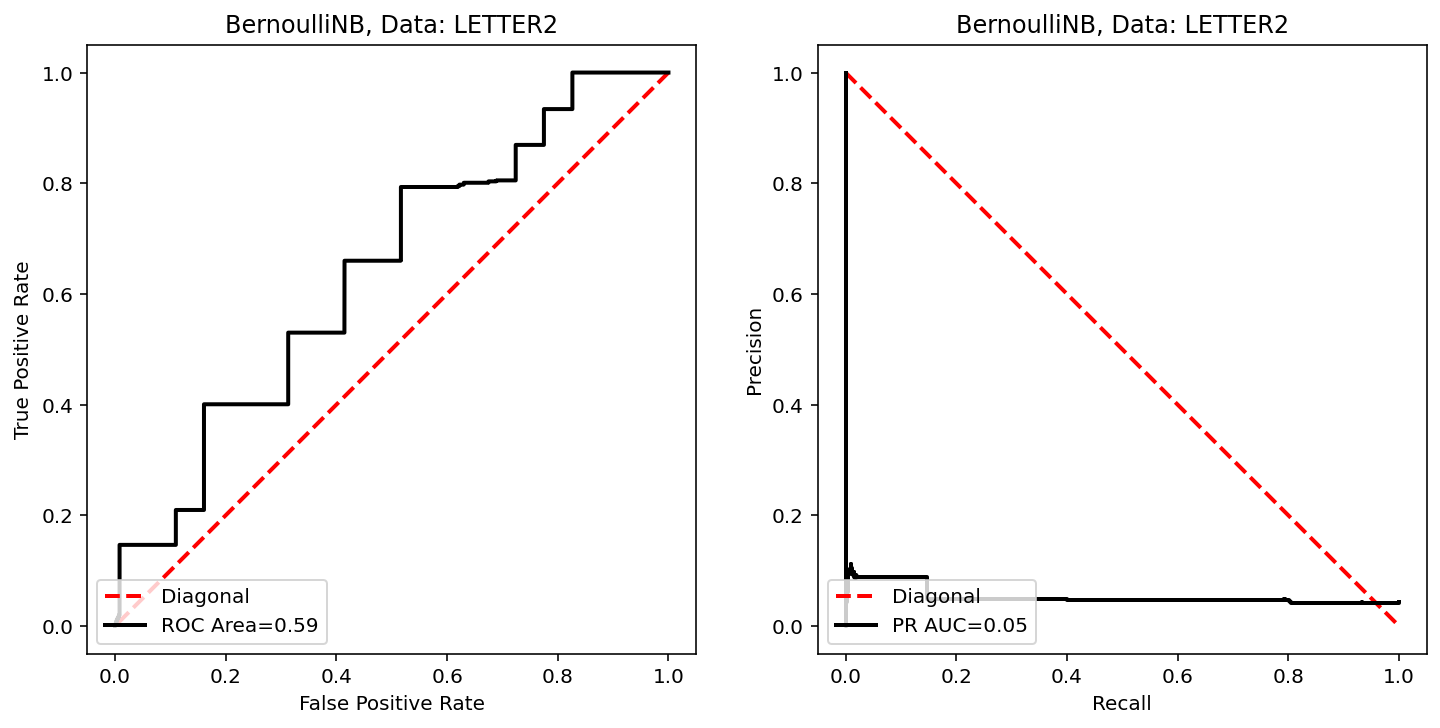

Ended LETTER2 in 2.736 seconds
Started on COVTYPE dataset


Started trial:  1

Best param for ACC: {'alpha': 0.0001}
Ended trial 1 in 0.880 seconds


Started trial:  2

Best param for ACC: {'alpha': 0.0001}
Ended trial 2 in 0.846 seconds


Started trial:  3

Best param for ACC: {'alpha': 0.01}
Ended trial 3 in 0.854 seconds


Started trial:  4

Best param for ACC: {'alpha': 10}
Ended trial 4 in 0.868 seconds


Started trial:  5

Best param for ACC: {'alpha': 1}
Ended trial 5 in 0.878 seconds




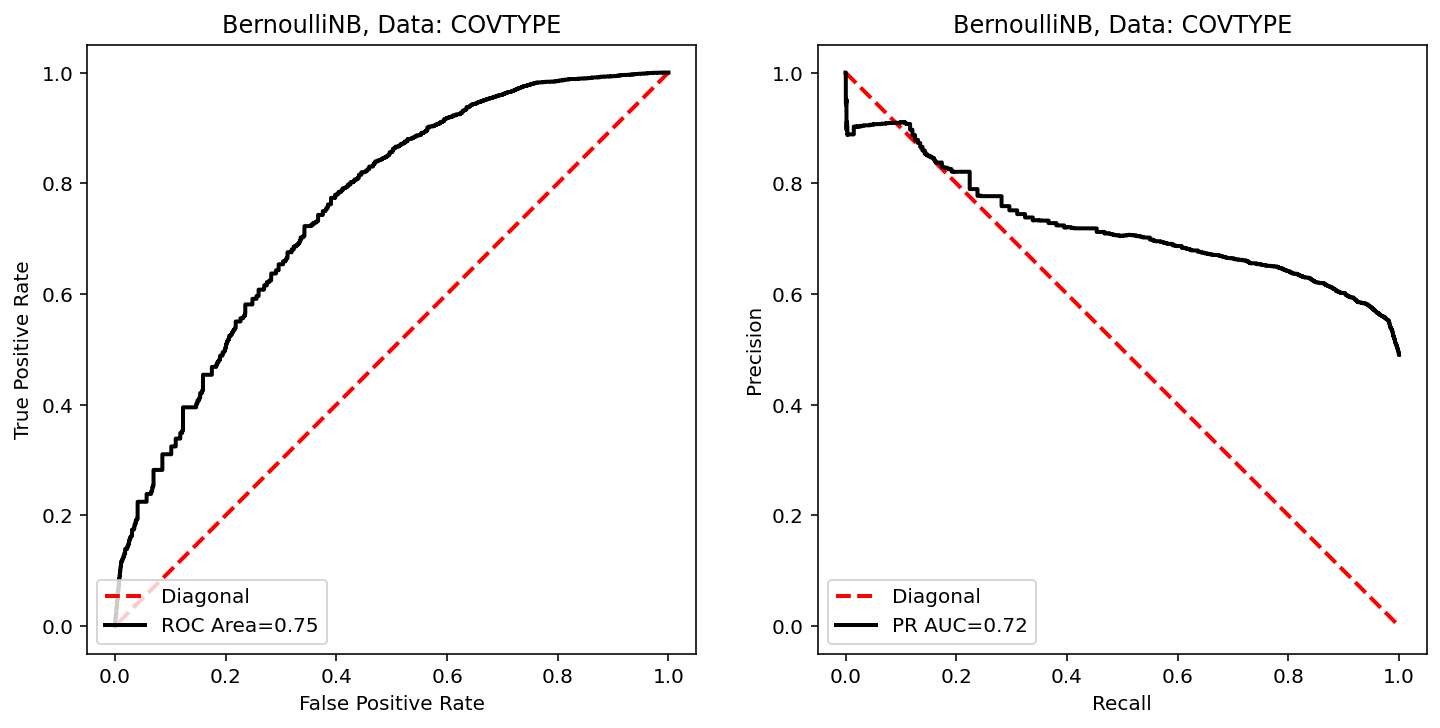

Ended COVTYPE in 5.117 seconds
Ended BernoulliNB() in 21.109 seconds

--------------------------------------------------------------



In [16]:
# algorithms = [LOGIT, TREES, FOREST, GBOOST, MLP_ADAM, NB]
learn(5, algorithms[5])

### Tables and Output

In [17]:

print('----------------------------------------------------------------')
print('----------------------------------------------------------------')

print("Table 2: mean test set performance")
print(algo_metric_df_test)
print('----------------------------------------------------------------')
print("Table 2b: Secondary results 1")
print(algo_metric_df_train)
print('----------------------------------------------------------------')
print('Table 3:')
print(algo_data_df)
print('----------------------------------------------------------------')
print('Raw training scores:')
print(raw_train)
print('----------------------------------------------------------------')
print('Raw test scores: Secondary results 2')
print(raw_test)
print('----------------------------------------------------------------')
print("---------------------- End ------------------------------------")

----------------------------------------------------------------
----------------------------------------------------------------
Table 2: mean test set performance
               ACC       APR       ROC
LOGIT     0.822754  0.623291  0.850184
TREES     0.867867  0.779514  0.893362
FOREST    0.900355  0.897413  0.946725
GBOOST    0.907358  0.906995  0.950503
MLP_ADAM  0.893842  0.881304  0.938188
NB        0.749619  0.502576  0.703253
----------------------------------------------------------------
Table 2b: Secondary results 1
              ACC       APR       ROC
LOGIT     0.82566  0.633612  0.856742
TREES     0.91844  0.896812  0.945291
FOREST    0.99996  1.000000  1.000000
GBOOST    0.97645  0.979642  0.989608
MLP_ADAM  0.93330  0.934849  0.970080
NB        0.75123  0.508511  0.708125
----------------------------------------------------------------
Table 3:
             ADULT   LETTER1   LETTER2   COVTYPE
LOGIT     0.832672  0.784137  0.650625  0.794205
TREES     0.817271  0.908687 

In [74]:
algo_data_df

,ADULT,LETTER1,LETTER2,COVTYPE
LOGIT,0.832672,0.784137,0.650625,0.794205
TREES,0.817271,0.908687,0.879192,0.782507
FOREST,0.839766,0.975356,0.976052,0.868150
GBOOST,0.862398,0.979594,0.976011,0.868472
MLP_ADAM,0.816646,0.975062,0.982937,0.843133
NB,0.777775,0.573208,0.543166,0.713114


In [19]:
algo_metric_df_test

,ACC,APR,ROC
LOGIT,0.822754,0.623291,0.850184
TREES,0.867867,0.779514,0.893362
FOREST,0.900355,0.897413,0.946725
GBOOST,0.907358,0.906995,0.950503
MLP_ADAM,0.893842,0.881304,0.938188
NB,0.749619,0.502576,0.703253


In [20]:
algo_metric_df_train

,ACC,APR,ROC
LOGIT,0.82566,0.633612,0.856742
TREES,0.91844,0.896812,0.945291
FOREST,0.99996,1.000000,1.000000
GBOOST,0.97645,0.979642,0.989608
MLP_ADAM,0.93330,0.934849,0.970080
NB,0.75123,0.508511,0.708125


In [33]:
p_val_test_metric = p_stats(raw_test, algo_metric_df_test, len(algo_names), len(metric_names), per_data=False)
print('p_val_test_metric: for Table 2')
print(p_val_test_metric);print()

p_val_train_metric =  p_stats(raw_train, algo_metric_df_train, len(algo_names), len(metric_names), per_data=False)
print('p_val_train_metric:')
print(p_val_train_metric);print()

p_val_test_data = p_stats(raw_test, algo_data_df, len(algo_names), len(data_list), per_data=True)
print('p_val_test_data: for Table 3')
print(p_val_test_data);print()


p_val_test_metric: for Table 2
[[2.56511462e-03 1.68311937e-04 9.81151549e-10]
 [1.10255795e-01 4.98769041e-06 4.53504733e-04]
 [7.54209149e-01 6.97785092e-01 7.95254229e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [5.74146761e-01 3.73886533e-01 4.47364196e-01]
 [1.55270332e-04 1.47757906e-07 5.96735797e-11]]

p_val_train_metric:
[[4.30254170e-10 3.06542425e-06 2.97695722e-19]
 [2.82589559e-05 6.06019201e-07 1.99291459e-06]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.68468418e-02 1.76615455e-02 2.15026048e-02]
 [6.83273763e-05 3.03292069e-03 5.91120341e-04]
 [9.88332280e-09 9.68784743e-10 1.27455615e-13]]

p_val_test_data: for Table 3
[[1.38819617e-01 5.40656472e-16 2.48266798e-03 8.57206544e-07]
 [4.40347518e-02 5.17725199e-11 3.15167623e-03 3.37763115e-08]
 [2.22889251e-01 5.73250095e-01 3.79939732e-01 9.80178609e-01]
 [1.00000000e+00 1.00000000e+00 3.89910556e-01 1.00000000e+00]
 [4.34961280e-02 5.36076575e-01 1.00000000e+00 5.23660156e-02]
 [1.43418505e-03 1.248842

In [34]:
p_val_test_metric = pd.DataFrame(p_val_test_metric)
p_val_test_metric

,0,1,2
0,0.002565,1.683119e-04,9.811515e-10
1,0.110256,4.987690e-06,4.535047e-04
2,0.754209,6.977851e-01,7.952542e-01
3,1.000000,1.000000e+00,1.000000e+00
4,0.574147,3.738865e-01,4.473642e-01
5,0.000155,1.477579e-07,5.967358e-11


In [35]:
p_val_test_data = pd.DataFrame(p_val_test_data)
p_val_test_data

,0,1,2,3
0,0.138820,5.406565e-16,0.002483,8.572065e-07
1,0.044035,5.177252e-11,0.003152,3.377631e-08
2,0.222889,5.732501e-01,0.379940,9.801786e-01
3,1.000000,1.000000e+00,0.389911,1.000000e+00
4,0.043496,5.360766e-01,1.000000,5.236602e-02
5,0.001434,1.248843e-33,0.000155,2.438795e-13


In [36]:
p_val_train_metric = pd.DataFrame(p_val_train_metric)
p_val_train_metric

,0,1,2
0,4.302542e-10,3.065424e-06,2.976957e-19
1,2.825896e-05,6.060192e-07,1.992915e-06
2,1.000000e+00,1.000000e+00,1.000000e+00
3,1.684684e-02,1.766155e-02,2.150260e-02
4,6.832738e-05,3.032921e-03,5.911203e-04
5,9.883323e-09,9.687847e-10,1.274556e-13


In [48]:
# raw_mean_test = np.mean(raw_test, axis=2)
# raw_mean_test 

In [47]:
raw_test.shape

(6, 4, 5, 3)

In [1]:
dfraw = pd.DataFrame(raw_test[5][3])
dfraw

NameError: ignored